In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import warnings

# Set plot style for visual clarity
plt.style.use('seaborn-v0_8')

**Table of contents**<a id='toc0_'></a>    
- [EDA](#toc1_)    
  - [Read in Data](#toc1_1_)    
  - [Overview of columns](#toc1_2_)    
  - [Preprocess materials](#toc1_3_)    
  - [Preprocess receivals](#toc1_4_)    
    - [Create daily aggregated receivals data](#toc1_4_1_)    
  - [Daily aggregated receivals EDA](#toc1_5_)    
    - [Domain Knowledge: Raw Material Receivals](#toc1_5_1_)    
    - [Interpretation: Checking if the Data Is Intuitive](#toc1_5_2_)    
    - [Understanding How the Data Was Generated](#toc1_5_3_)    
    - [Autocorrelation and Partial Autocorrelation Analysis](#toc1_5_4_)    
  - [Cumulative-format receivals EDA](#toc1_6_)    
    - [Interpretation: Cumulative Receivals](#toc1_6_1_)    
- [Feature Engineering](#toc2_)    
    - [Feature Significance Analysis](#toc2_1_1_)    
  - [How were the receivals ordered?](#toc2_2_)    
    - [Preprocess purchases](#toc2_2_1_)    
    - [Compare actual arrival date and planned delivery date](#toc2_2_2_)    
      - [Comparison of Delivery and Arrival Dates](#toc2_2_2_1_)    
      - [Continued Comparison of Delivery and Arrival Dates](#toc2_2_2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[EDA](#toc0_)

## <a id='toc1_1_'></a>[Read in Data](#toc0_)

In [2]:
# Load the receival data
receivals = pd.read_csv('./data/kernel/receivals.csv')
# Load purchases
purchases = pd.read_csv('./data/kernel/purchase_orders.csv')
# Load Materials
materials = pd.read_csv('./data/extended/materials.csv')
# Load Transportation
transportation = pd.read_csv('./data/extended/transportation.csv')

In [3]:
receivals.columns

Index(['rm_id', 'product_id', 'purchase_order_id', 'purchase_order_item_no',
       'receival_item_no', 'batch_id', 'date_arrival', 'receival_status',
       'net_weight', 'supplier_id'],
      dtype='object')

In [4]:
purchases.columns

Index(['purchase_order_id', 'purchase_order_item_no', 'quantity',
       'delivery_date', 'product_id', 'product_version', 'created_date_time',
       'modified_date_time', 'unit_id', 'unit', 'status_id', 'status'],
      dtype='object')

In [5]:
materials.columns

Index(['rm_id', 'product_id', 'product_version', 'raw_material_alloy',
       'raw_material_format_type', 'stock_location'],
      dtype='object')

## <a id='toc1_2_'></a>[Overview of columns](#toc0_)

In [6]:
def explore_dataframe(df, name="DataFrame", plot=True, max_plots=15):
    """
    Summarize dataframe columns with dtype, non-null counts, unique values,
    and optionally plot distributions for the first few columns.
    """
    print(f"Overview of {name}")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # Summary table
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'non_null_count': df.notnull().sum(),
        'null_count': df.isnull().sum(),
        'unique_values': df.nunique()
    })
    display(summary)

    if plot:
        num_cols = df.select_dtypes(include=['int64', 'float64']).columns
        cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns

        # Numeric columns
        for i, col in enumerate(num_cols[:max_plots]):
            plt.figure(figsize=(6, 3))
            sns.histplot(df[col].dropna(), kde=True, bins=30)
            plt.title(f"Distribution of numeric feature: {col}")
            plt.show()

        # Categorical columns
        for i, col in enumerate(cat_cols[:max_plots]):
            plt.figure(figsize=(6, 3))
            df[col].value_counts(dropna=False).head(20).plot(kind='bar')
            plt.title(f"Top categories in: {col}")
            plt.show()

    return summary

Overview of Receivals Data
Shape: 122590 rows × 10 columns



,dtype,non_null_count,null_count,unique_values
rm_id,float64,122533,57,203
product_id,float64,122533,57,54
purchase_order_id,float64,122537,53,7173
purchase_order_item_no,float64,122537,53,92
receival_item_no,int64,122590,0,15
batch_id,float64,64765,57825,64765
date_arrival,object,122590,0,87527
receival_status,object,122590,0,4
net_weight,float64,122522,68,14824
supplier_id,int64,122590,0,255


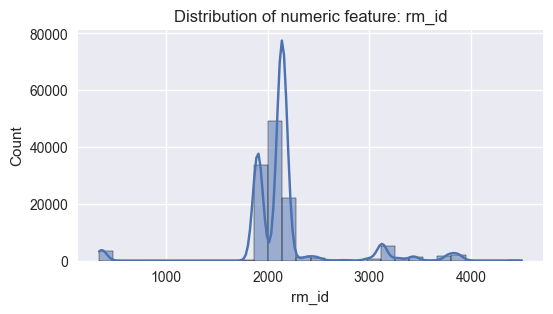

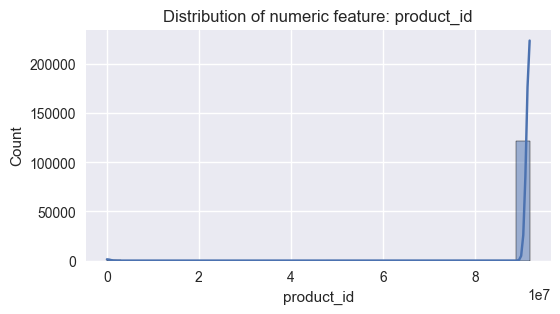

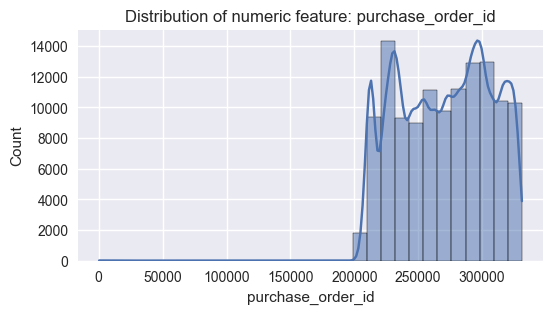

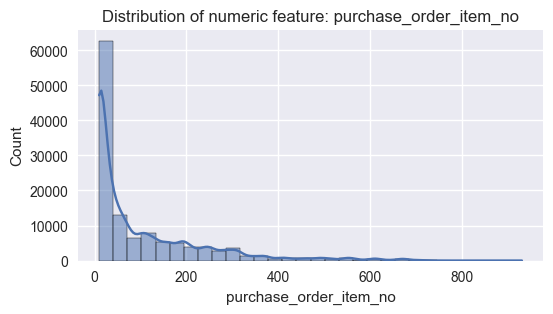

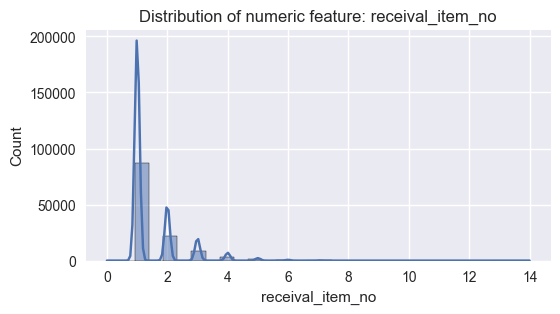

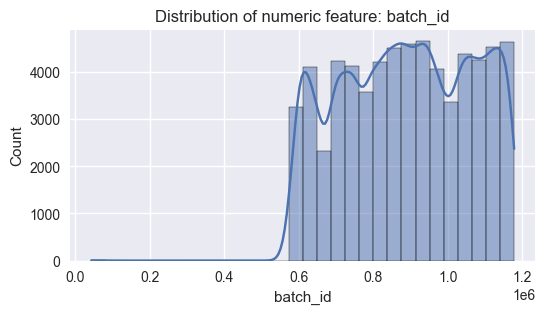

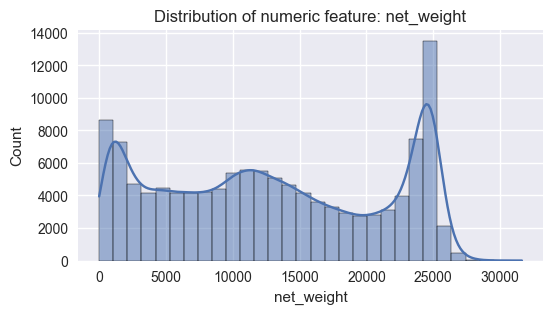

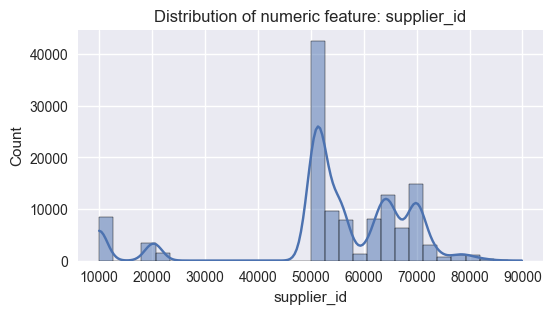

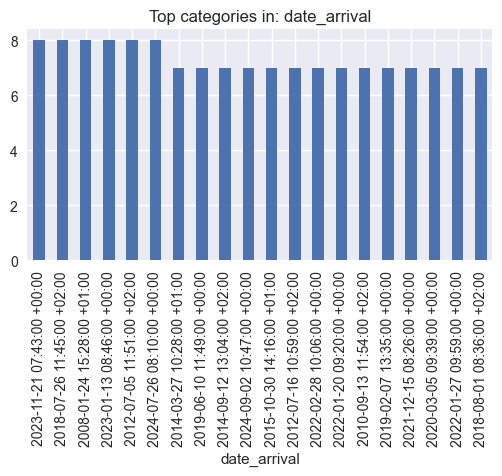

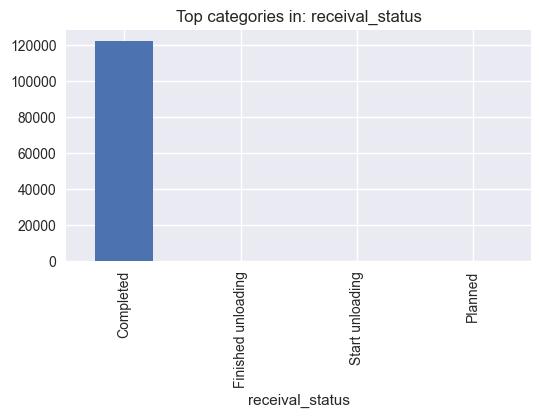

In [7]:
receivals_summary = explore_dataframe(receivals, "Receivals Data")

Overview of Purchases Data
Shape: 33171 rows × 12 columns



,dtype,non_null_count,null_count,unique_values
purchase_order_id,int64,33171,0,8135
purchase_order_item_no,int64,33171,0,94
quantity,float64,33171,0,4997
delivery_date,object,33171,0,2332
product_id,int64,33171,0,77
product_version,int64,33171,0,9
created_date_time,object,33171,0,14657
modified_date_time,object,32679,492,22845
unit_id,float64,33127,44,2
unit,object,33127,44,2


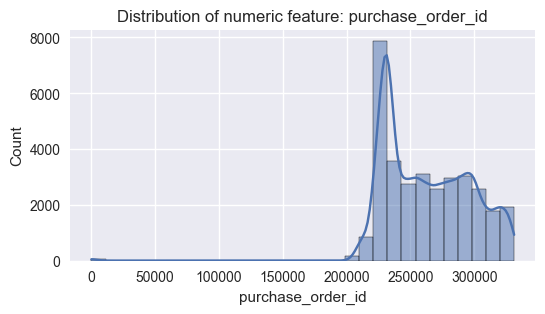

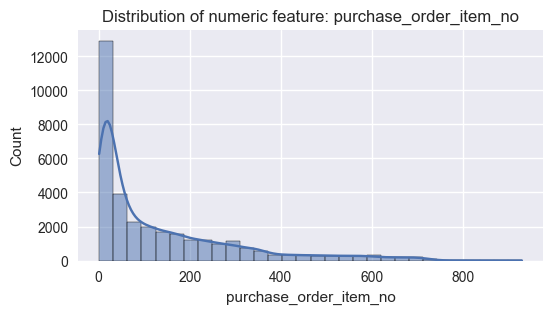

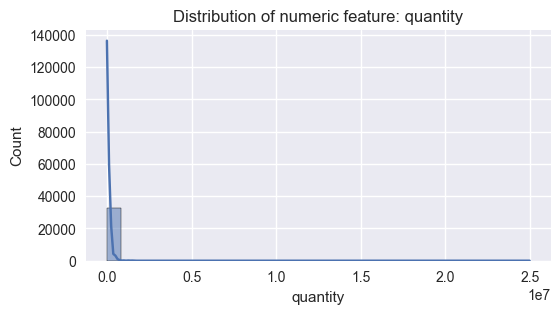

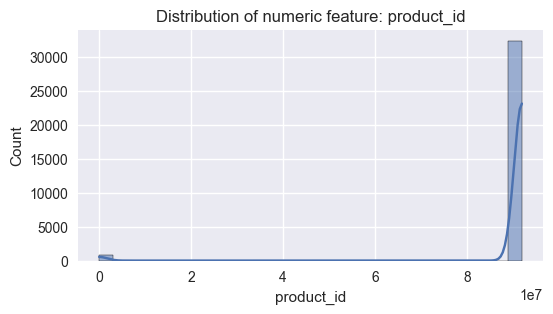

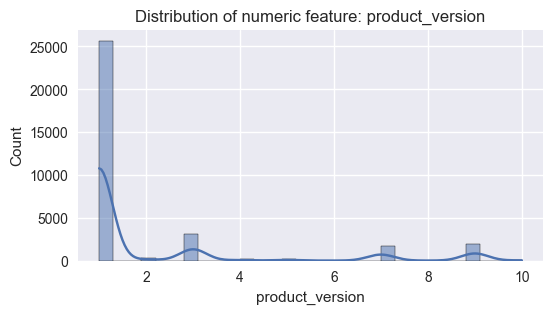

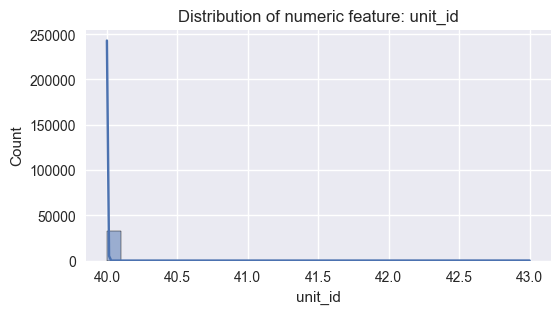

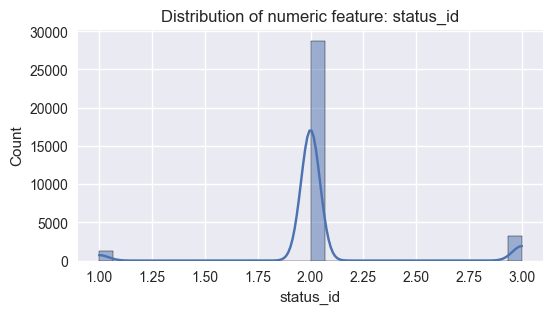

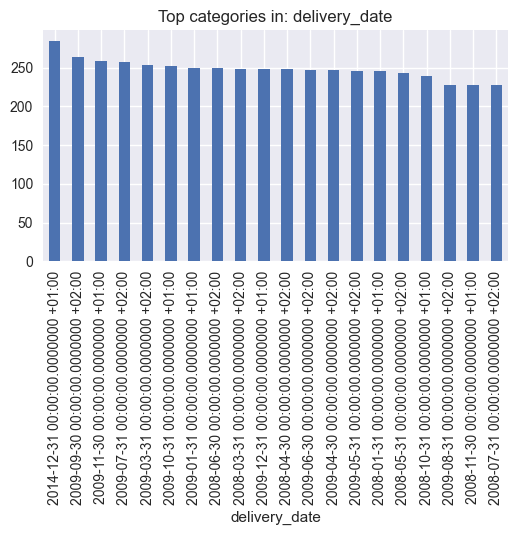

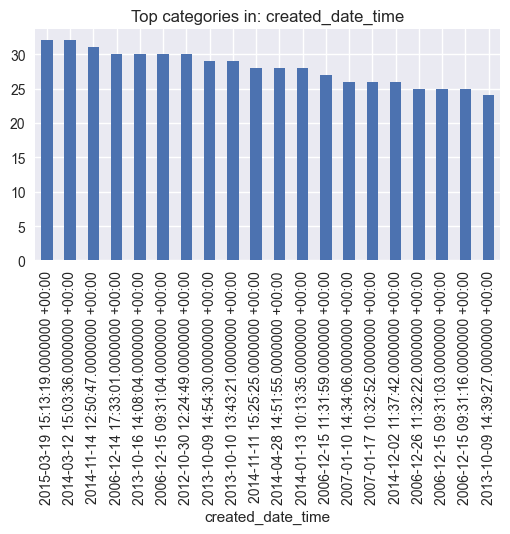

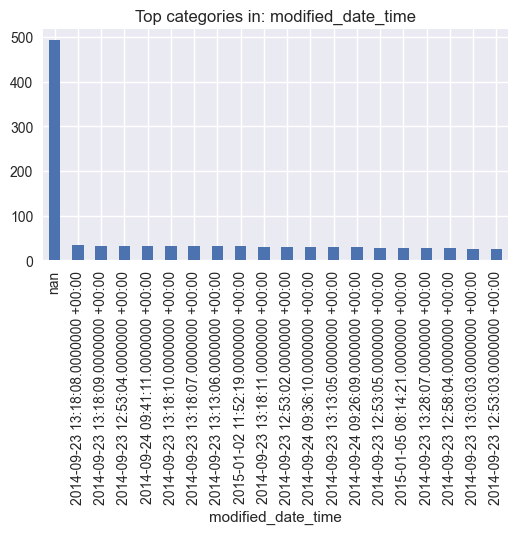

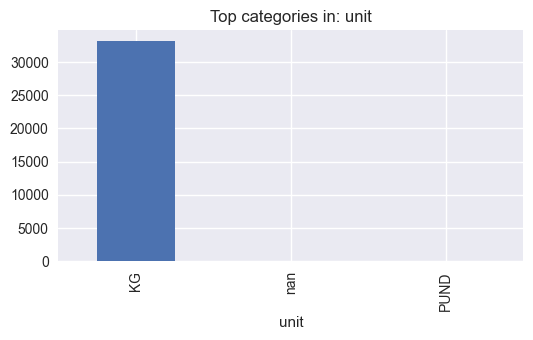

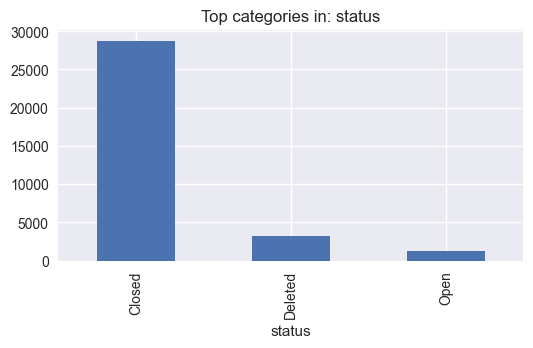

In [8]:
purchases_summary = explore_dataframe(purchases, "Purchases Data")

Overview of Materials Data
Shape: 1218 rows × 6 columns



,dtype,non_null_count,null_count,unique_values
rm_id,float64,1217,1,203
product_id,float64,1217,1,54
product_version,float64,1217,1,65
raw_material_alloy,object,1217,1,180
raw_material_format_type,float64,1217,1,25
stock_location,object,1217,1,153


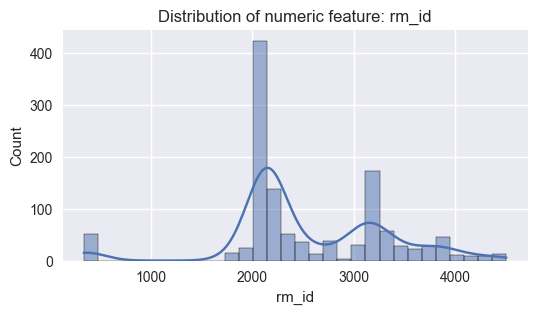

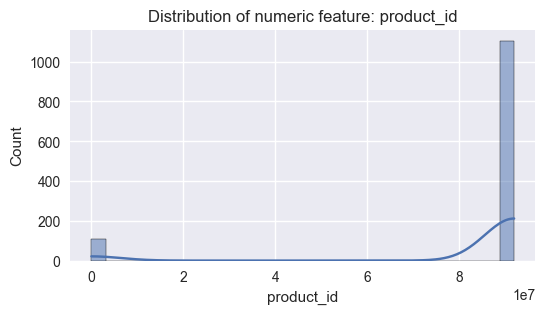

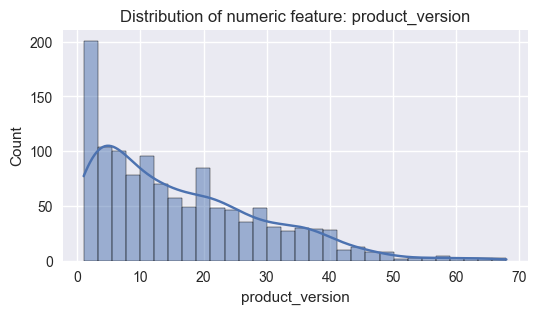

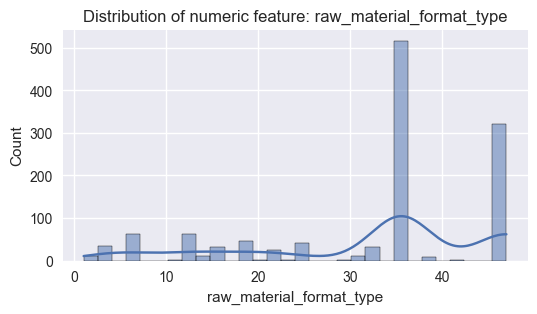

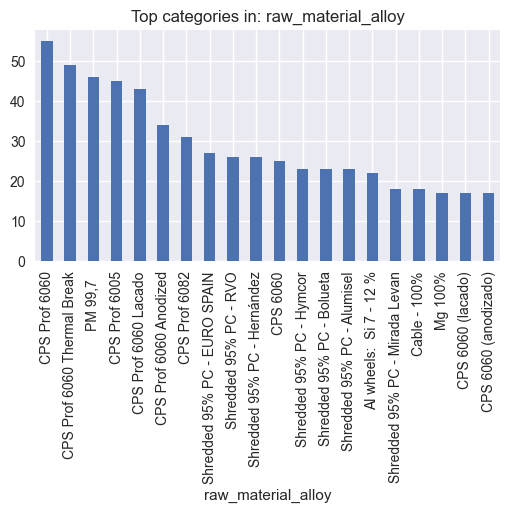

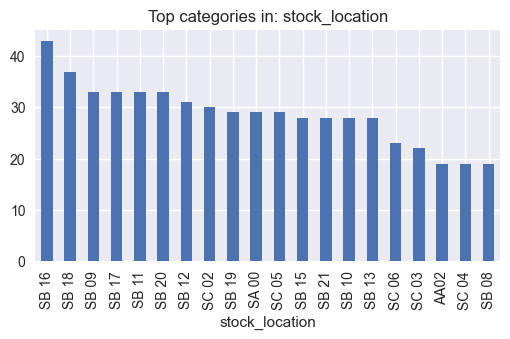

In [9]:
materials_summary = explore_dataframe(materials, "Materials Data")

Overview of Transportation Data
Shape: 122590 rows × 23 columns



,dtype,non_null_count,null_count,unique_values
rm_id,float64,122533,57,203
product_id,float64,122533,57,54
purchase_order_id,float64,122537,53,7173
purchase_order_item_no,float64,122537,53,92
receival_item_no,int64,122590,0,15
batch_id,float64,64765,57825,64765
transporter_name,object,122590,0,25
vehicle_no,object,122590,0,17029
unit_status,object,122582,8,5
vehicle_start_weight,float64,122570,20,2204


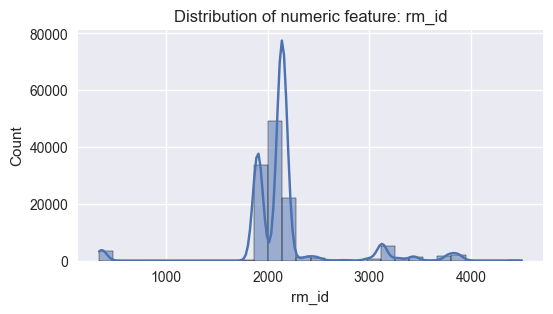

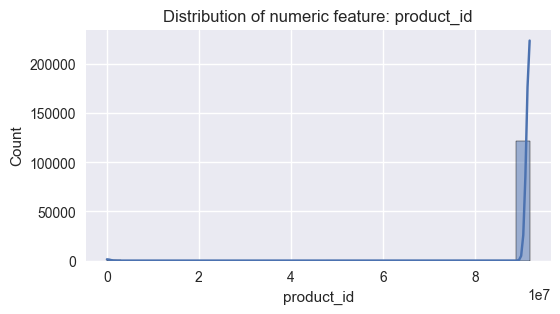

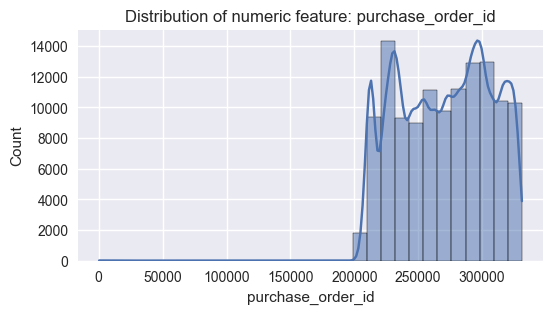

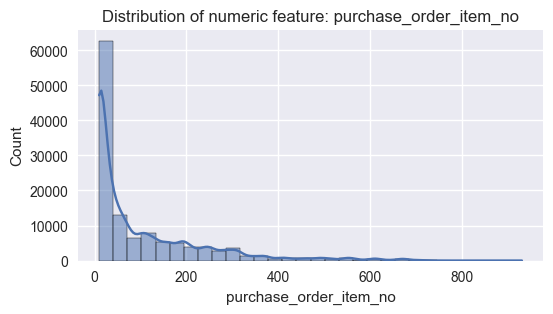

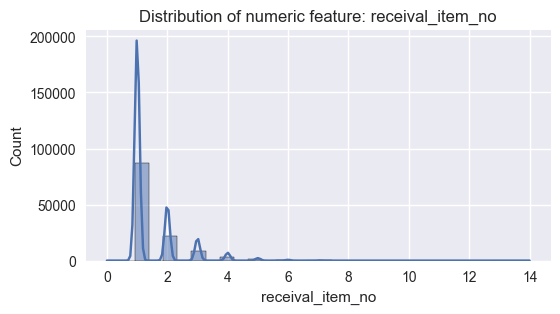

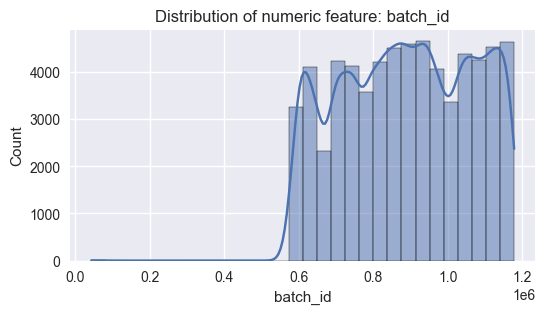

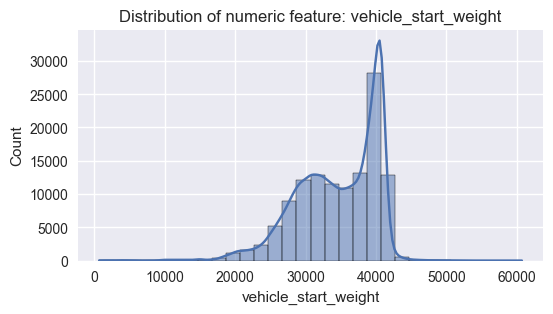

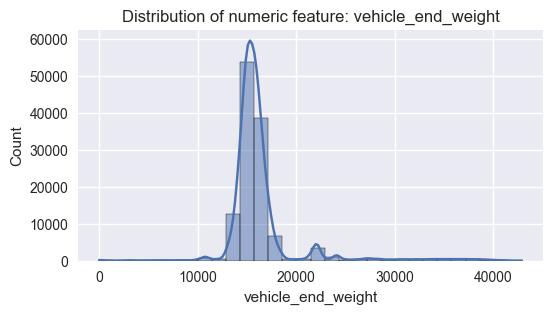

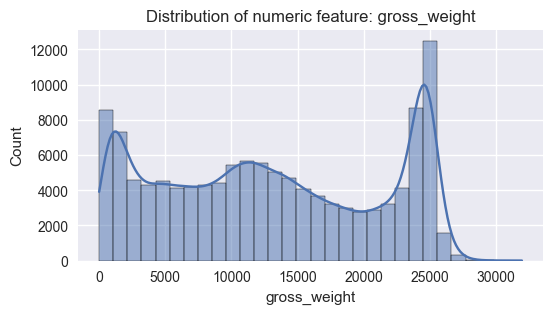

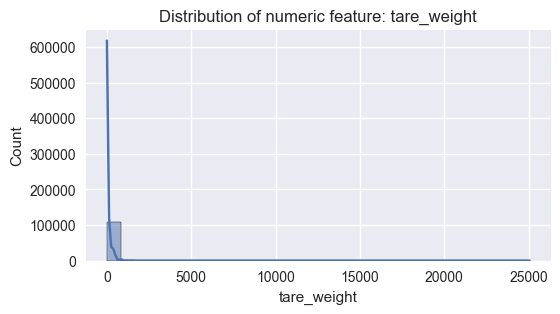

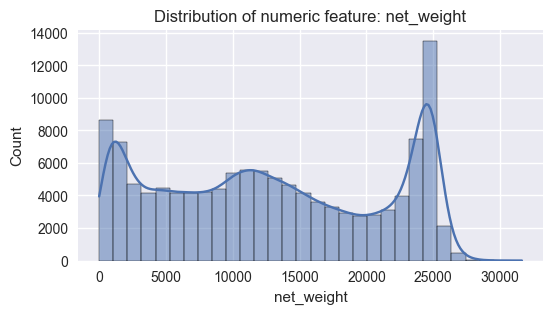

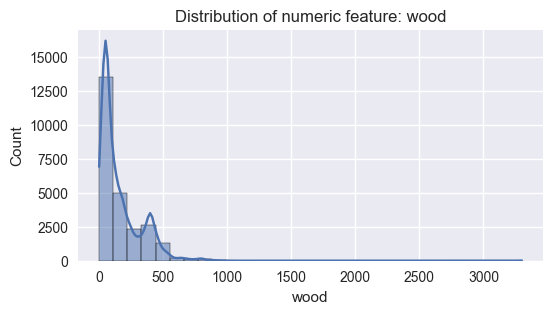

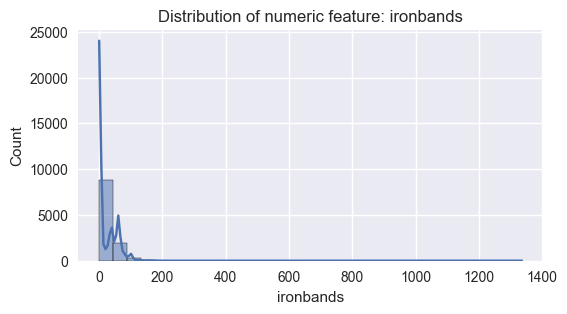

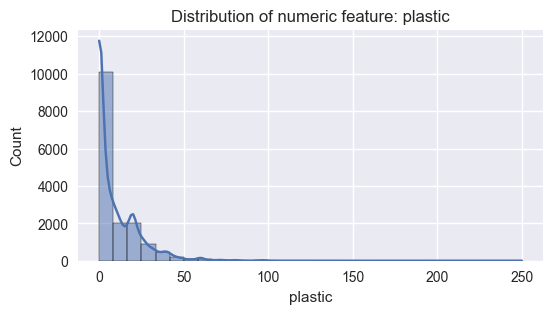

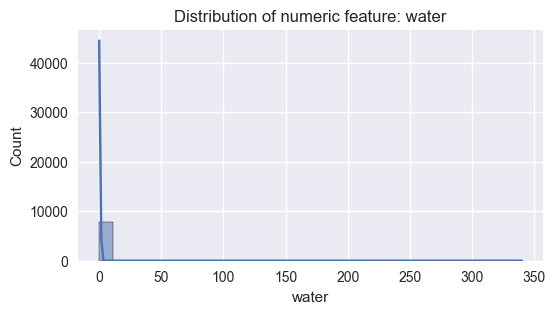

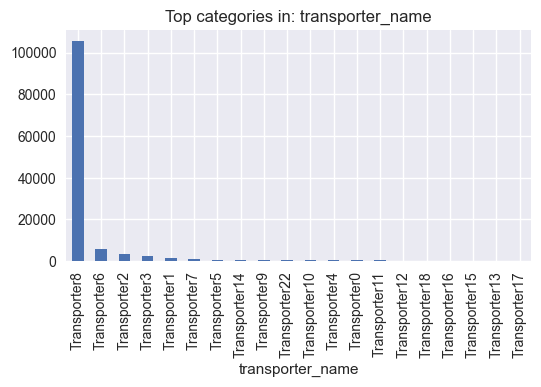

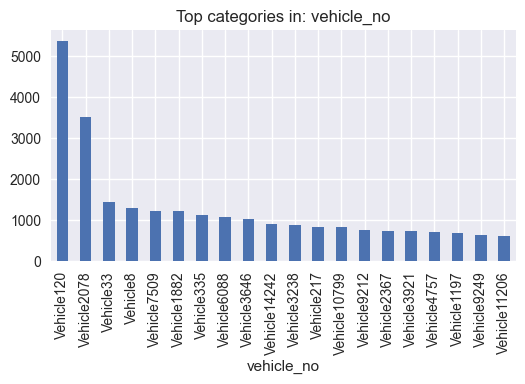

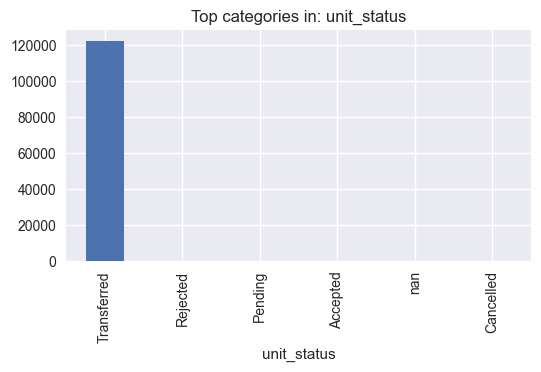

In [10]:
transportation_summary = explore_dataframe(transportation, "Transportation Data")

## <a id='toc1_3_'></a>[Preprocess materials](#toc0_)

In [11]:
# The materials dataset contains metadata about raw materials, including their product versions,
# storage locations, and potential deletion flags embedded in the 'stock_location' column.
# Each raw material (rm_id) can have multiple product versions, where the latest version represents
# its current status. The goal is to identify which materials were active within the forecasting time
# window based on inferred deletion dates and versioning information.

In [12]:
def load_active_materials(materials,
                          start='2025-01-01',
                          end='2025-05-31'):
    """
    Loads and filters material data to return:
      1. active_rms: list of raw material IDs active in the given period
      2. product_to_rm: mapping from product_id to rm_id
      3. materials_status: DataFrame with one row per rm_id (latest version) + 'is_active' flag

    Logic:
      - Only keep newest product_version per rm_id
      - Parse 'DELETED_<date>' as deletion date
      - A material is active if deletion_date is NA or >= start
    """

    def parse_deletion_date(s):
        if isinstance(s, str) and s.startswith("DELETED_"):
            try:
                # Extract only the part after DELETED_ up to the next underscore or space
                after_prefix = s.split("_", 1)[1]
                date_str = after_prefix.split("_")[0].split()[0].replace(":", ".")
                return pd.to_datetime(date_str, format="%d.%m.%Y", errors="coerce")
            except Exception:
                return pd.NaT
        return pd.NaT

    materials = materials.dropna(subset=["product_id", "rm_id"])

    materials["deletion_date"] = materials["stock_location"].apply(parse_deletion_date)

    materials_sorted = materials.sort_values(["rm_id", "product_version"], ascending=[True, False])
    materials_latest = materials_sorted.drop_duplicates(subset="rm_id", keep="first").reset_index(drop=True)

    start = pd.Timestamp(start)
    end = pd.Timestamp(end)

    materials_latest["is_active"] = (
        materials_latest["deletion_date"].isna() |
        (materials_latest["deletion_date"] >= start)
    )
    materials_latest["is_active_after_horizon"] = (
        materials_latest["deletion_date"].isna() |
        (materials_latest["deletion_date"] > end)
    )

    materials_active = materials_latest[materials_latest["is_active"]].copy()
    active_rms = materials_active["rm_id"].dropna().unique().tolist()

    product_to_rm = (
        materials[["product_id", "rm_id"]]
        .dropna()
        .drop_duplicates()
        .set_index("product_id")["rm_id"]
        .to_dict()
    )

    print(f"✅ Active raw materials in {start.year}-H1: {len(active_rms)}")
    print(f"✅ Created mapping for {len(product_to_rm)} product_ids.")
    print(f"ℹ️ Total distinct rm_ids: {materials_latest['rm_id'].nunique()}")
    if len(product_to_rm) > 0:
        print("Example mappings:", list(product_to_rm.items())[:5])

    return active_rms, product_to_rm, materials_latest

In [13]:
active_rms, product_to_rm, materials_latest = load_active_materials(materials, start='2025-01-01', end='2025-05-31')

✅ Active raw materials in 2025-H1: 174
✅ Created mapping for 54 product_ids.
ℹ️ Total distinct rm_ids: 203
Example mappings: [(91900170.0, 2201.0), (91900143.0, 3865.0), (91900146.0, 3941.0), (91900182.0, 3821.0), (91900152.0, 4443.0)]


/tmp/ipykernel_410320/3143729468.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  materials["deletion_date"] = materials["stock_location"].apply(parse_deletion_date)


In [14]:
# Inspect results
print(f"Number of active raw materials: {len(active_rms)}")
print(f"\nExample mapping product to rm: {list(product_to_rm.items())[:5]}\n")

display(materials_latest)

Number of active raw materials: 174

Example mapping product to rm: [(91900170.0, 2201.0), (91900143.0, 3865.0), (91900146.0, 3941.0), (91900182.0, 3821.0), (91900152.0, 4443.0)]



,rm_id,product_id,product_version,raw_material_alloy,raw_material_format_type,stock_location,deletion_date,is_active,is_active_after_horizon
0,342.0,91900170.0,1.0,SB06 Traders,24.0,DELETED_28.02:2011_SB06 anodiz,2011-02-28,False,False
1,343.0,91900143.0,2.0,SB02 606035,24.0,SB 02,NaT,True,True
2,345.0,91900143.0,2.0,SA10 606035,3.0,DELETED_28.02:2011_ST01,2011-02-28,False,False
3,346.0,91900146.0,2.0,SA15 600540,3.0,DELETED_28.02:2011_SA 300370,2011-02-28,False,False
4,347.0,91900143.0,2.0,SA13 606020,3.0,DELETED_28.02:2011_SA13 6035,2011-02-28,False,False
...,...,...,...,...,...,...,...,...,...
198,4461.0,91901250.0,2.0,CPS 6005 (anodizado),35.0,SB 08 A,NaT,True,True
199,4462.0,91901113.0,3.0,CPS 6082 (anodizado),35.0,SB 16,NaT,True,True
200,4463.0,91900304.0,3.0,CPS 6082 (lacado),35.0,SA 00,NaT,True,True
201,4481.0,91901215.0,9.0,Melé 95% PC - Acín,47.0,SB 18 A,NaT,True,True


In [15]:
# Besides this we did not find other useful information in materials.

## <a id='toc1_4_'></a>[Preprocess receivals](#toc0_)

The EDA will focus on daily level receivals because we later train our model on daily level data. This aligns with the standard time series modelling approach.

In [16]:
# The receivals dataset contains detailed records of raw material deliveries, where each row represents
# a single receival event linked to a specific raw material (rm_id), product, and purchase order.
# It includes timestamps (date_arrival), delivery quantities (net_weight), and supplier information,
# allowing us to trace how materials are received over time and from which sources.
# 
# This dataset serves as the foundation for understanding delivery dynamics and building predictive models
# of future incoming material quantities. In our analysis, we will explore both:
#   (1) aggregated daily receival data to uncover temporal and seasonal patterns, and
#   (2) the cumulative-format data required for the actual Kaggle submission,
#       where for each raw material and each date, we compute the total delivered weight
#       over the period [January 1, year; date] for every year available in the dataset.

In [17]:
# Convert 'date_arrival' to timezone-naive datetime
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)

# Drop all rows where rm_id is missing
receivals = receivals.dropna(subset=['rm_id']).copy()

receivals = receivals.dropna(subset=['net_weight']).copy()
receivals = receivals.drop_duplicates().copy()

# Keep only active raw materials
receivals = receivals[receivals["rm_id"].isin(active_rms)].copy()

receivals

,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id
0,365.0,91900143.0,208545.0,10.0,1,NaN,2004-06-15 11:34:00,Completed,11420.0,52062
1,365.0,91900143.0,208545.0,10.0,2,NaN,2004-06-15 11:34:00,Completed,13760.0,52062
2,365.0,91900143.0,208490.0,10.0,1,NaN,2004-06-15 11:38:00,Completed,11281.0,50468
3,365.0,91900143.0,208490.0,10.0,2,NaN,2004-06-15 11:38:00,Completed,13083.0,50468
6,365.0,91900143.0,208532.0,10.0,1,NaN,2004-06-15 11:46:00,Completed,14840.0,20023
...,...,...,...,...,...,...,...,...,...,...
122585,3421.0,91900160.0,328740.0,30.0,1,1178422.0,2024-12-19 10:26:00,Completed,1220.0,69879
122586,2145.0,91900146.0,328740.0,20.0,2,1178431.0,2024-12-19 10:26:00,Completed,850.0,69879
122587,3865.0,91900143.0,328740.0,10.0,3,1178432.0,2024-12-19 10:26:00,Completed,14170.0,69879
122588,3901.0,91901440.0,330334.0,10.0,1,1178427.0,2024-12-19 10:54:00,Completed,15020.0,72195


### <a id='toc1_4_1_'></a>[Create daily aggregated receivals data](#toc0_)

In [18]:
# Aggregate to daily totals per rm_id
receivals_daily = (
    receivals.groupby(['rm_id', receivals['date_arrival'].dt.floor('D')])['net_weight']
    .sum()
    .reset_index()
    .rename(columns={'date_arrival': 'date'})
)

# Sort values for shifting
receivals_daily = receivals_daily.sort_values(['rm_id', 'date'])

receivals_daily

,rm_id,date,net_weight
0,343.0,2005-03-29,21760.0
1,362.0,2005-04-04,23270.0
2,362.0,2005-05-27,1500.0
3,362.0,2018-07-20,45320.0
4,365.0,2004-06-15,83784.0
...,...,...,...
39095,4463.0,2024-10-17,2000.0
39096,4481.0,2024-10-29,24680.0
39097,4481.0,2024-11-27,22340.0
39098,4501.0,2024-12-02,23580.0


In [19]:
len(set(receivals_daily['rm_id']))

174

In [20]:
# Ensure consistent daily time series across all rm_ids

# Determine full daily date range across all receivals
full_dates = pd.date_range(
    start=receivals_daily['date'].min(),
    end=receivals_daily['date'].max(),
    freq='D'
)

# Create a MultiIndex with all rm_id–date combinations
full_index = pd.MultiIndex.from_product(
    [receivals_daily['rm_id'].unique(), full_dates],
    names=['rm_id', 'date']
)

# Reindex and fill missing net_weight values with 0
receivals_daily_full = (
    receivals_daily
    .set_index(['rm_id', 'date'])
    .reindex(full_index, fill_value=0)
    .reset_index()
)

print(f"✅ Created consistent daily time series with {len(receivals_daily_full):,} rows")
print(f"   (was {len(receivals_daily):,} before filling)")
display(receivals_daily_full.head())

✅ Created consistent daily time series with 1,303,782 rows
   (was 39,100 before filling)


,rm_id,date,net_weight
0,343.0,2004-06-15,0.0
1,343.0,2004-06-16,0.0
2,343.0,2004-06-17,0.0
3,343.0,2004-06-18,0.0
4,343.0,2004-06-19,0.0


## <a id='toc1_5_'></a>[Daily aggregated receivals EDA](#toc0_)

### <a id='toc1_5_1_'></a>[Domain Knowledge: Raw Material Receivals](#toc0_)

In industrial production, **raw material receivals** represent the recorded deliveries of input materials from suppliers to the factory. Each delivery is linked to a purchase order and supplier, and the total amount received determines whether production can continue without interruption.  

Delivery patterns are shaped by **supplier schedules, production planning, and contractual agreements**. Many suppliers deliver at regular weekly or monthly intervals, while weekends, holidays, or maintenance periods often lead to temporary drops in activity or to larger shipments shortly afterward.  

The **daily delivery quantities** vary widely between materials. Some are supplied in small batches of a few hundred kilograms, while others arrive in truckloads or containers—up to several tens of tons per day. Very high daily totals may indicate combined or delayed deliveries, whereas days with no recorded deliveries can reflect sufficient inventory levels, supplier delays, or planned production pauses.


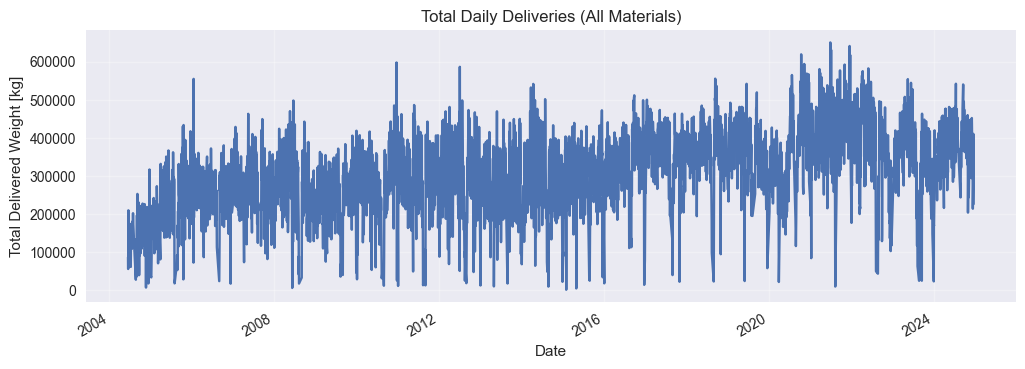

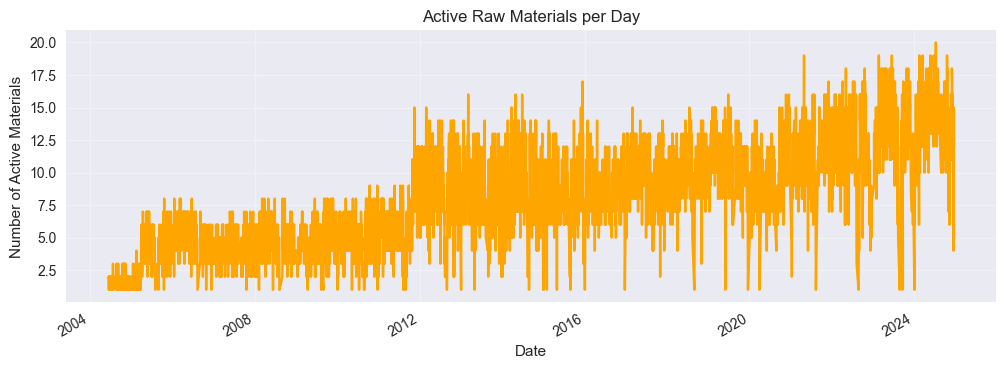

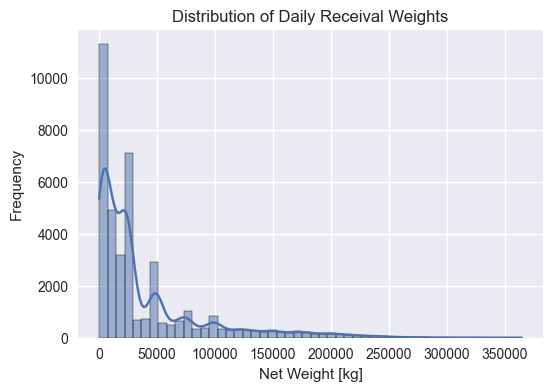

count     39100.000000
mean      37995.343248
std       49762.282872
min           0.000000
25%        5400.000000
50%       22130.000000
75%       49080.000000
max      364632.000000
Name: net_weight, dtype: float64

In [21]:
# Check if the data is intuitive

# Total daily deliveries across all materials
daily_total = receivals_daily.groupby('date')['net_weight'].sum()

plt.figure(figsize=(12, 4))
daily_total.plot()
plt.title('Total Daily Deliveries (All Materials)')
plt.xlabel('Date')
plt.ylabel('Total Delivered Weight [kg]')
plt.grid(True, alpha=0.3)
plt.savefig('Total_Daily_Deliveries_(All_Materials).png')
plt.show()

# Number of active materials per day
daily_active = receivals_daily.groupby('date')['rm_id'].nunique()

plt.figure(figsize=(12, 4))
daily_active.plot(color='orange')
plt.title('Active Raw Materials per Day')
plt.xlabel('Date')
plt.ylabel('Number of Active Materials')
plt.grid(True, alpha=0.3)
plt.savefig('Active_Raw_Materials_per_Day.png')
plt.show()

# Distribution of daily receival weights
plt.figure(figsize=(6, 4))
sns.histplot(receivals_daily['net_weight'], bins=50, kde=True)
plt.title('Distribution of Daily Receival Weights')
plt.xlabel('Net Weight [kg]')
plt.ylabel('Frequency')
plt.savefig('Distribution_of_Daily_Receival_Weights.png')
plt.show()

# Summary statistics
receivals_daily['net_weight'].describe()

### <a id='toc1_5_2_'></a>[Interpretation: Checking if the Data Is Intuitive](#toc0_)

The **daily receival weights** are highly skewed: most days show deliveries below about **50,000 kg**, while a few reach well above **300,000 kg**. The median of roughly **22 t** indicates that small and medium shipments are most common, whereas large spikes likely represent combined or delayed deliveries.  

The **total daily deliveries across all materials** fluctuate around a stable average but show frequent short-term drops and peaks. These variations likely correspond to weekends, holidays, or temporary production breaks, which are typical in industrial supply chains. Over time, the overall activity increases, reflecting the addition of more raw materials and a possible rise in production capacity.  

The **number of active raw materials per day** supports this trend: in early years, only a few materials are active, while by 2024 this number has grown to nearly **20**. The day-to-day variability looks realistic, as not every material is delivered continuously but rather according to supplier and production schedules.


Top 5 materials by total delivered weight: [2130.0, 1903.0, 2160.0, 2140.0, 1909.0]


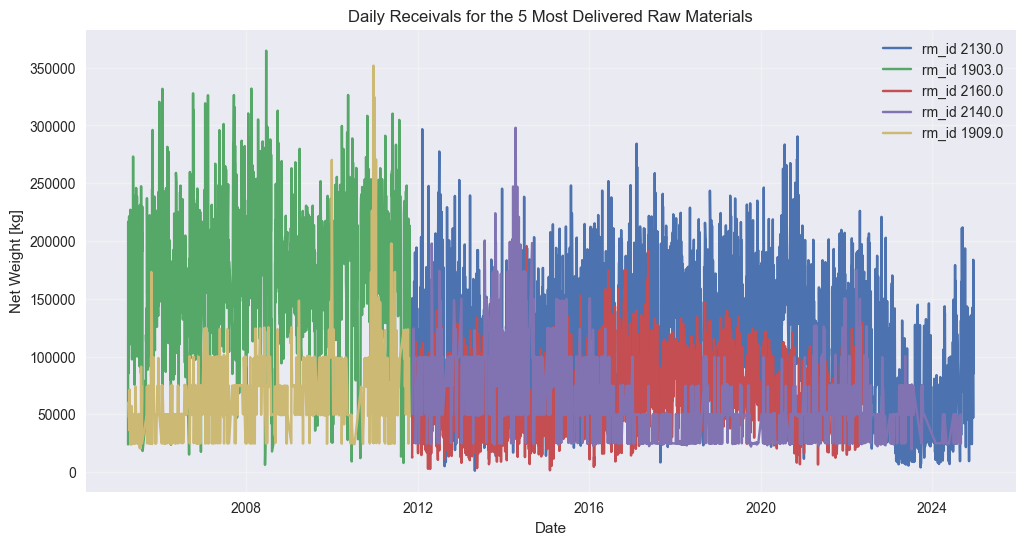

Continuity overview (first 20 rows):


,rm_id,total_days,inactive_periods,is_continuous,received_last_2m_2024
0,343.0,1,0,True,False
1,362.0,4856,2,False,False
2,365.0,289,2,False,False
3,366.0,289,3,False,False
4,380.0,120,1,False,False
5,381.0,274,6,False,False
6,383.0,232,4,False,False
7,386.0,2593,47,False,False
8,387.0,113,1,False,False
9,1842.0,19,0,True,False



Percentage of continuously received materials: 23.6%
Percentage of irregularly received materials: 76.4%

Number of materials active in the last two months of 2024: 33
Share of all materials active in that period: 19.0%


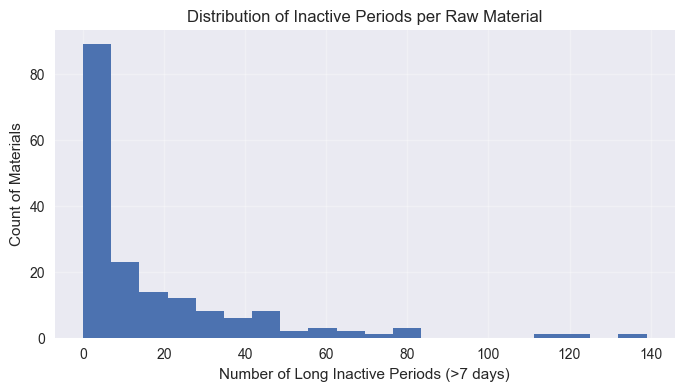

In [22]:
# Understand how the data was generated

# The goal of this section is to visualize how raw materials are received over time
# and to check whether deliveries occur continuously or in irregular intervals.
# We will:
#   1. Identify the five most delivered raw materials.
#   2. Plot their daily delivery time series to see activity patterns and gaps.
#   3. Create a summary DataFrame showing how continuous each material’s time series is,
#      allowing short inactive gaps (up to 7 days).
#   4. Check whether each material was still being received in the last two months of 2024.

# Identify top 5 materials by total delivered weight
top5_rms = (
    receivals_daily.groupby("rm_id")["net_weight"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

print("Top 5 materials by total delivered weight:", list(top5_rms))

# Visualize their daily delivery patterns
plt.figure(figsize=(12, 6))
for rm in top5_rms:
    subset = receivals_daily[receivals_daily["rm_id"] == rm]
    plt.plot(subset["date"], subset["net_weight"], label=f"rm_id {rm}")

plt.title("Daily Receivals for the 5 Most Delivered Raw Materials")
plt.xlabel("Date")
plt.ylabel("Net Weight [kg]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Analyze continuity of deliveries for all raw materials
continuity_records = []

# Define time tolerance (max inactive gap allowed to still count as continuous)
max_gap_days = 7
cutoff_date = pd.Timestamp("2024-11-01")

for rm, group in receivals_daily.groupby("rm_id"):
    # Sort by date and ensure daily frequency
    ts = group.set_index("date")["net_weight"].asfreq("D")
    ts = ts.fillna(0)

    # Identify inactive periods (gaps longer than 7 days)
    inactive_periods = (ts == 0).astype(int)
    # Find transitions from active to inactive and back
    inactive_runs = (inactive_periods.diff() == 1).cumsum()
    run_lengths = inactive_periods.groupby(inactive_runs).sum()
    long_inactive_periods = run_lengths[run_lengths > max_gap_days].count()

    # Check if received in the last two months of 2024
    received_last_2m = (ts.loc[cutoff_date:] > 0).any()

    continuity_records.append({
        "rm_id": rm,
        "total_days": len(ts),
        "inactive_periods": int(long_inactive_periods),
        "is_continuous": long_inactive_periods == 0,
        "received_last_2m_2024": received_last_2m
    })

continuity_df = pd.DataFrame(continuity_records)

# Display summary of continuity
print("Continuity overview (first 20 rows):")
display(continuity_df.head(20))

# Share of continuous vs irregular materials
summary = continuity_df["is_continuous"].value_counts(normalize=True) * 100
print(f"\nPercentage of continuously received materials: {summary.get(True, 0):.1f}%")
print(f"Percentage of irregularly received materials: {summary.get(False, 0):.1f}%")

# Identify materials active in the last two months of 2024
active_last2m_rms = continuity_df.loc[
    continuity_df["received_last_2m_2024"], "rm_id"
].tolist()

share_active_last2m = len(active_last2m_rms) / len(continuity_df) * 100

print(f"\nNumber of materials active in the last two months of 2024: {len(active_last2m_rms)}")
print(f"Share of all materials active in that period: {share_active_last2m:.1f}%")

# how many inactive periods per material
plt.figure(figsize=(8, 4))
continuity_df["inactive_periods"].hist(bins=20)
plt.title("Distribution of Inactive Periods per Raw Material")
plt.xlabel("Number of Long Inactive Periods (>7 days)")
plt.ylabel("Count of Materials")
plt.grid(alpha=0.3)
plt.show()

### <a id='toc1_5_3_'></a>[Understanding How the Data Was Generated](#toc0_)

The plots of the top five raw materials show that deliveries occur irregularly, with clear gaps between active periods. This means the data is **event-based**, not continuously recorded. Each entry represents a shipment that only occurs when materials are delivered.  

Each raw material (`rm_id`) forms its own **independent time series** with distinct temporal patterns. Some materials are delivered frequently, while others show sporadic or seasonal activity. This confirms that the dataset consists of **separate delivery logs** per material rather than a uniform daily measurement process.

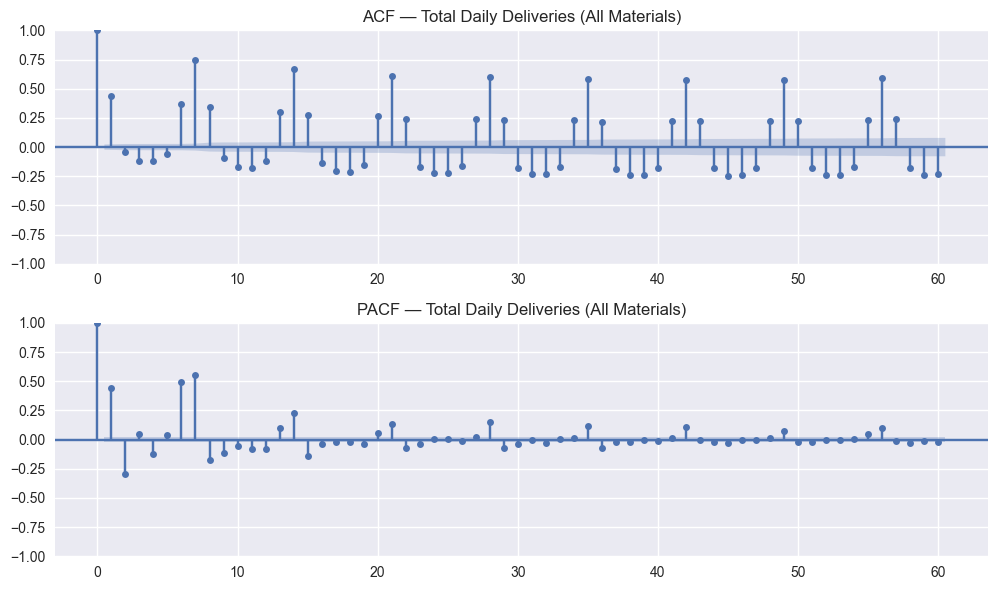

Sampled materials for ACF/PACF inspection: [3941.0, 3701.0, 2441.0]


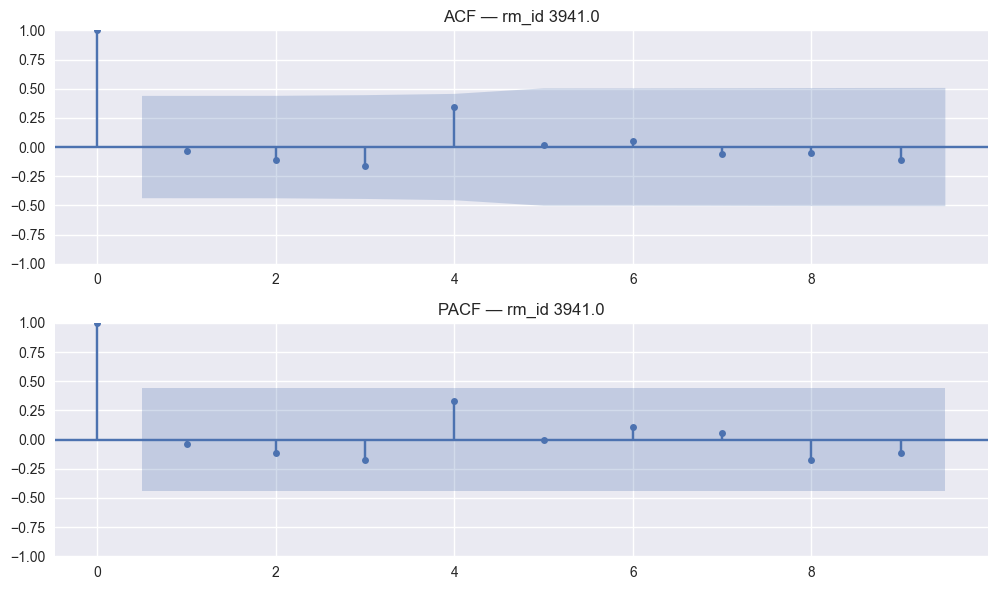

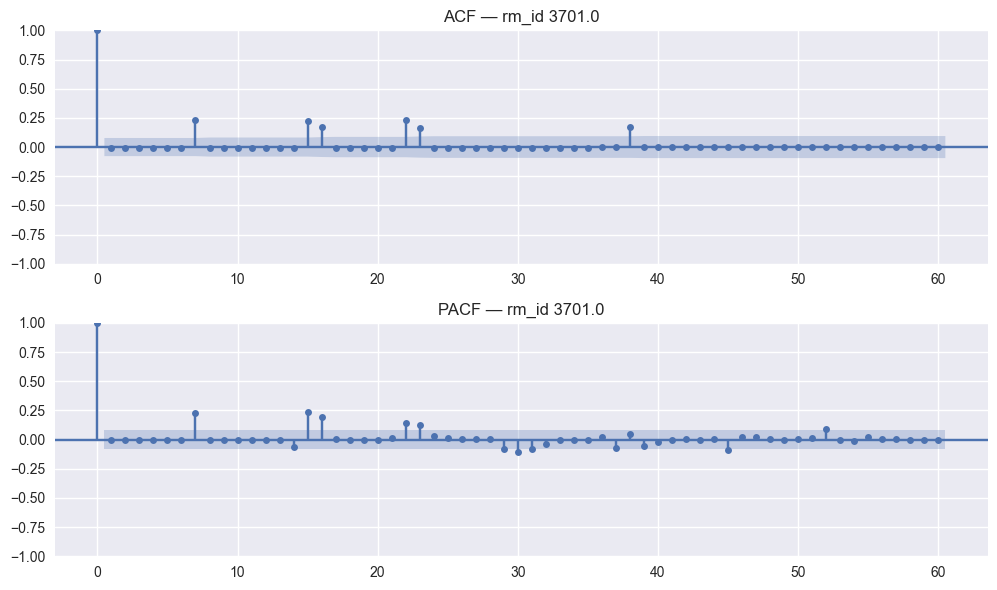

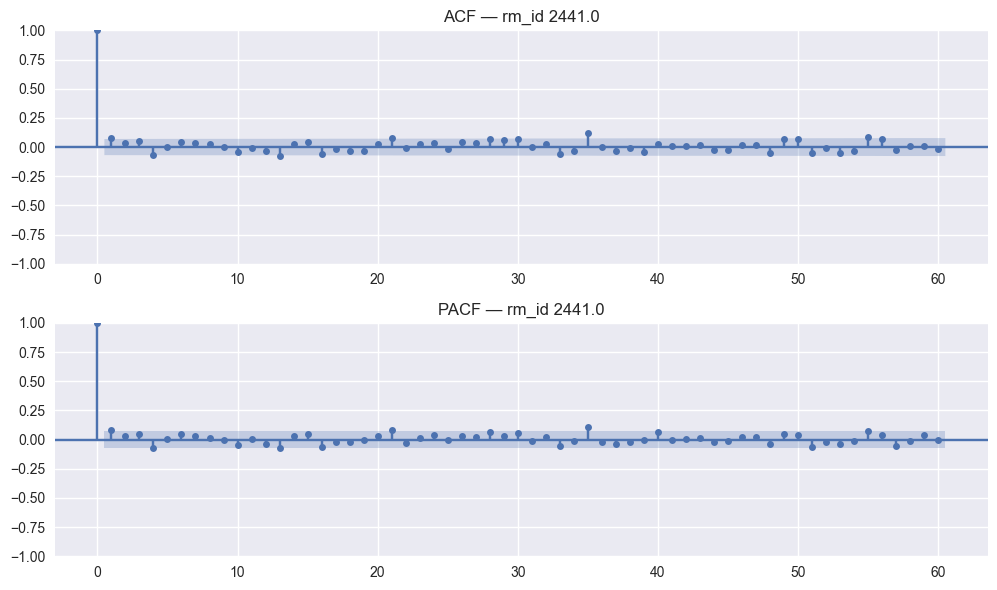

Summary of strongest autocorrelation lags per material:


,rm_id,top_acf_lags,acf_values
0,343.0,[],[]
1,362.0,"[1, 2, 3]","[-0.0, -0.0, -0.0]"
2,365.0,"[7, 14, 21]","[0.63, 0.5, 0.47]"
3,366.0,"[14, 2, 1]","[0.12, 0.08, 0.06]"
4,380.0,"[1, 2, 3]","[-0.0, -0.0, -0.0]"
5,381.0,"[28, 10, 23]","[0.15, 0.0, -0.0]"
6,383.0,"[9, 23, 8]","[0.16, 0.16, 0.13]"
7,386.0,"[26, 16, 14]","[0.01, -0.0, -0.01]"
8,387.0,"[1, 2, 3]","[-0.0, -0.0, -0.0]"
9,1842.0,"[4, 7, 8]","[0.2, 0.17, -0.03]"



Materials showing possible weekly seasonality (lag ≈ 7): [365.0, 1842.0, 1843.0, 1852.0, 1853.0, 1854.0, 1866.0, 1868.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905.0, 1907.0, 1908.0, 1909.0, 2130.0, 2131.0, 2132.0, 2133.0, 2135.0, 2138.0, 2140.0, 2142.0, 2144.0, 2145.0, 2146.0, 2147.0, 2149.0, 2150.0, 2151.0, 2152.0, 2153.0, 2155.0, 2159.0, 2160.0, 2222.0, 2223.0, 2261.0, 2304.0, 2322.0, 2343.0, 2347.0, 2348.0, 2401.0, 2481.0, 2482.0, 2601.0, 2741.0, 2981.0, 3005.0, 3121.0, 3122.0, 3123.0, 3124.0, 3125.0, 3126.0, 3142.0, 3265.0, 3282.0, 3362.0, 3421.0, 3441.0, 3642.0, 3701.0, 3761.0, 3781.0, 3865.0, 3901.0, 4222.0, 4302.0, 4441.0, 4443.0]
Share of all materials with weekly seasonality: 42.0%


In [23]:
# Autocorrelation and Partial Autocorrelation Analysis
# --------------------------------------------------------------
# Goal: Examine temporal dependencies and potential seasonality patterns.
# We first analyze aggregated total deliveries over all materials,
# then inspect selected individual raw materials (rm_id-level),
# and finally summarize the strongest autocorrelation lags for all materials.


# ACF and PACF for total aggregated daily deliveries
daily_total = receivals_daily.groupby('date')['net_weight'].sum().asfreq('D').fillna(0)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(daily_total, lags=60, ax=ax[0])
plot_pacf(daily_total, lags=60, ax=ax[1])
ax[0].set_title("ACF — Total Daily Deliveries (All Materials)")
ax[1].set_title("PACF — Total Daily Deliveries (All Materials)")
plt.tight_layout()
plt.show()

# Interpretation expectation
# • Gradual ACF decay → persistence in total deliveries (daily dependence)
# • Peaks around lag 7 → weekly seasonality
# • PACF cutoffs → short-term autoregressive behavior (e.g., AR(1) or AR(7))

# ACF/PACF for a few representative materials

# Randomly sample 3 materials for inspection
sample_rms = receivals_daily['rm_id'].drop_duplicates().sample(3, random_state=42).tolist()
print(f"Sampled materials for ACF/PACF inspection: {sample_rms}")

for rm in sample_rms:
    # Build continuous daily time series for this material
    ts = (
        receivals_daily.query("rm_id == @rm")
        .set_index('date')['net_weight']
        .asfreq('D')
        .fillna(0)
    )

    # Skip very short series
    if len(ts) < 15:
        print(f"Skipping rm_id {rm} — too few observations ({len(ts)} days)")
        continue

    # Limit number of lags to at most half of the series length
    lags = min(60, len(ts) // 2 - 1)

    # Plot ACF and PACF
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(ts, lags=lags, ax=axes[0])
    plot_pacf(ts, lags=lags, ax=axes[1])
    axes[0].set_title(f"ACF — rm_id {rm}")
    axes[1].set_title(f"PACF — rm_id {rm}")
    plt.tight_layout()
    plt.show()
    
# --- Quantitative summary of strongest autocorrelation lags per rm_id ---
def compute_top_acf_lags(ts, max_lag=30, top_k=3):
    """
    Compute the top K non-zero lags with highest absolute autocorrelation.
    Skips very short or constant series safely.
    """
    ts = ts.dropna()
    if len(ts) < 10 or ts.nunique() < 2:
        return [], []

    # Suppress warnings for flat or short series
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        lags = min(max_lag, len(ts)//2 - 1)
        acf_vals = acf(ts, nlags=lags, fft=True)

    df = pd.DataFrame({'lag': np.arange(len(acf_vals)), 'acf': acf_vals})
    df = df[df['lag'] > 0].sort_values('acf', ascending=False).head(top_k)
    return df['lag'].tolist(), [round(v, 2) for v in df['acf'].tolist()]


summary_records = []
for rm, group in receivals_daily.groupby('rm_id'):
    ts = group.set_index('date')['net_weight'].asfreq('D').fillna(0)
    lags, vals = compute_top_acf_lags(ts)
    summary_records.append({'rm_id': rm, 'top_acf_lags': lags, 'acf_values': vals})

acf_summary_df = pd.DataFrame(summary_records)

# --- Display results ---
print("Summary of strongest autocorrelation lags per material:")
display(acf_summary_df.head(10))

# --- Check for weekly seasonality (lag ≈ 7) ---
seasonal_candidates = acf_summary_df[
    acf_summary_df['top_acf_lags'].apply(lambda x: 7 in x)
]['rm_id'].tolist()

share_weekly = len(seasonal_candidates) / len(acf_summary_df) * 100 if len(acf_summary_df) > 0 else 0

print(f"\nMaterials showing possible weekly seasonality (lag ≈ 7): {seasonal_candidates}")
print(f"Share of all materials with weekly seasonality: {share_weekly:.1f}%")

### <a id='toc1_5_4_'></a>[Autocorrelation and Partial Autocorrelation Analysis](#toc0_)

The ACF and PACF of the **total daily receivals** show clear **cyclic patterns**, indicating that delivery activity follows a regular weekly rhythm. This is consistent with the industrial context where shipments are typically organized around working days.  

When looking at the **PACF plots for individual raw materials**, we observe mostly **weak or short-lived autocorrelation**. Only a few materials exhibit distinct spikes, and when present, the **strongest partial autocorrelation appears around lag 7**, corresponding to a weekly delivery cycle.  
Overall, this suggests that most materials are delivered irregularly, with only limited temporal dependence beyond short-term or weekly effects.


## <a id='toc1_6_'></a>[Cumulative-format receivals EDA](#toc0_)

In [24]:
receivals_full = receivals_daily

In [25]:
# Add year column
receivals_full["year"] = receivals_full["date"].dt.year

# Compute cumulative weights per rm_id × year
receivals_full["cum_weight"] = (
    receivals_full.groupby(["rm_id", "year"])["net_weight"].cumsum()
)

# Build the rolling forecasting dataframe
# Each row = cumulative total from Jan 1 of that year to that day's end
receivals_ts = (
    receivals_full.assign(
        forecast_start_date=lambda x: pd.to_datetime(x["year"].astype(str) + "-01-01"),
        forecast_end_date=lambda x: x["date"]
    )
    [["date", "forecast_start_date", "forecast_end_date", "rm_id", "year", "cum_weight"]]
    .rename(columns={"cum_weight": "weight_kg"})
    .sort_values(["rm_id", "forecast_end_date"])
    .reset_index(drop=True)
)

num_years = receivals_ts["year"].nunique()
print(f"✅ Created forecasting dataframe with {len(receivals_ts):,} rows across {num_years} years.")
display(receivals_ts)

✅ Created forecasting dataframe with 39,100 rows across 21 years.


,date,forecast_start_date,forecast_end_date,rm_id,year,weight_kg
0,2005-03-29,2005-01-01,2005-03-29,343.0,2005,21760.0
1,2005-04-04,2005-01-01,2005-04-04,362.0,2005,23270.0
2,2005-05-27,2005-01-01,2005-05-27,362.0,2005,24770.0
3,2018-07-20,2018-01-01,2018-07-20,362.0,2018,45320.0
4,2004-06-15,2004-01-01,2004-06-15,365.0,2004,83784.0
...,...,...,...,...,...,...
39095,2024-10-17,2024-01-01,2024-10-17,4463.0,2024,2000.0
39096,2024-10-29,2024-01-01,2024-10-29,4481.0,2024,24680.0
39097,2024-11-27,2024-01-01,2024-11-27,4481.0,2024,47020.0
39098,2024-12-02,2024-01-01,2024-12-02,4501.0,2024,23580.0


Top 10 rm_ids by total cumulative deliveries: [1903.0, 2130.0, 2160.0, 2140.0, 365.0, 3781.0, 3126.0, 3865.0, 1909.0, 2482.0]


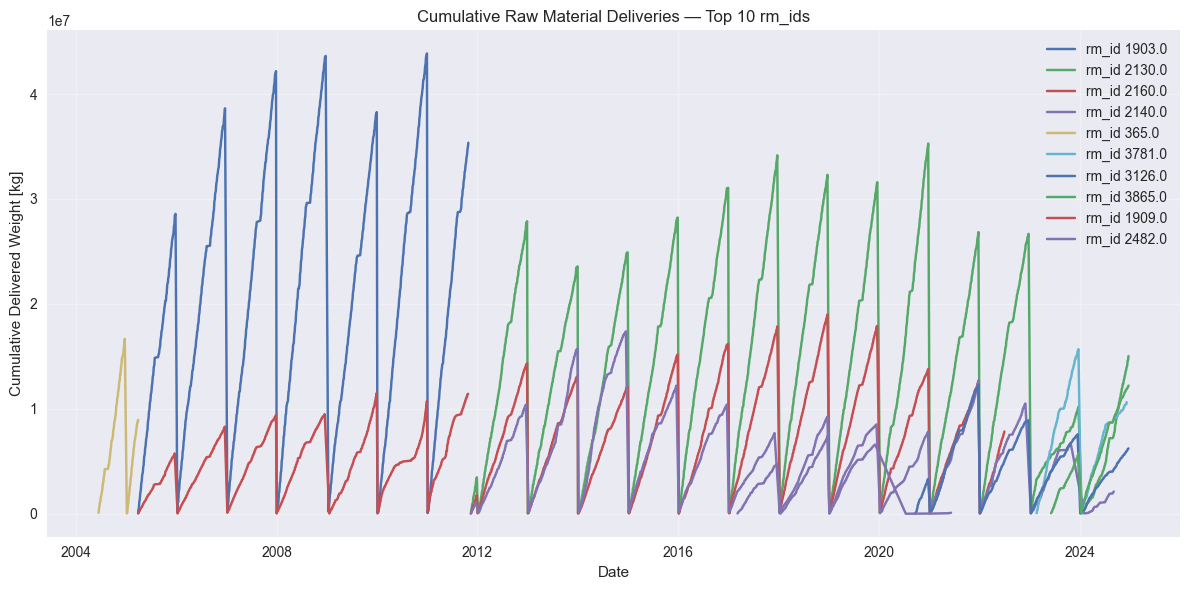

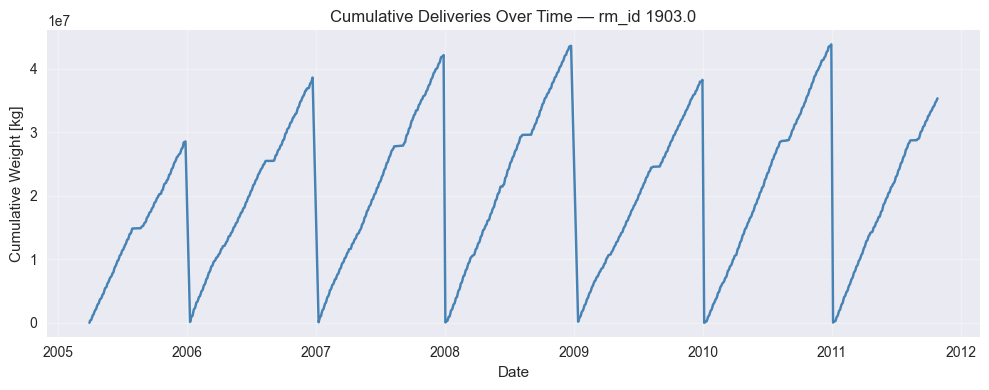

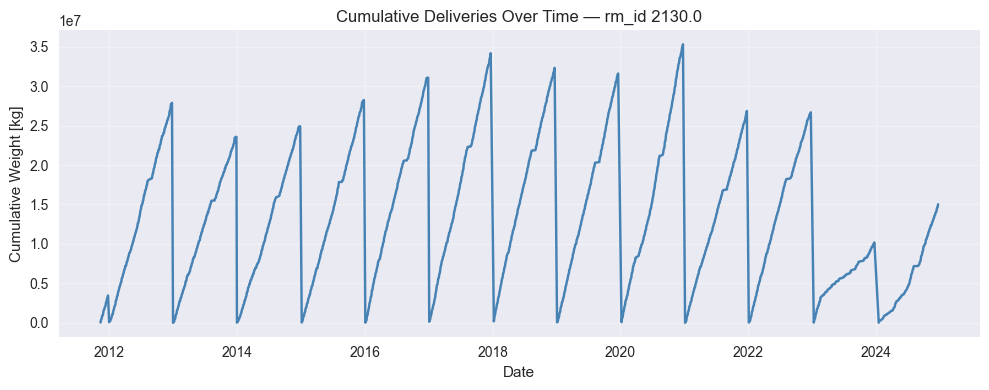

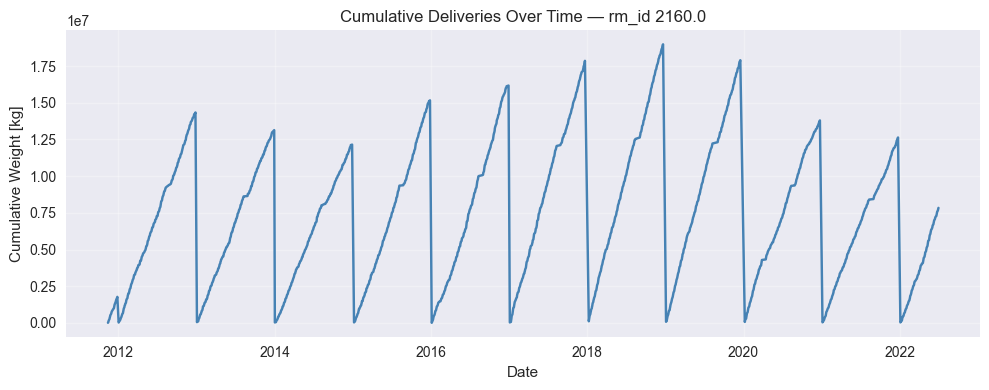

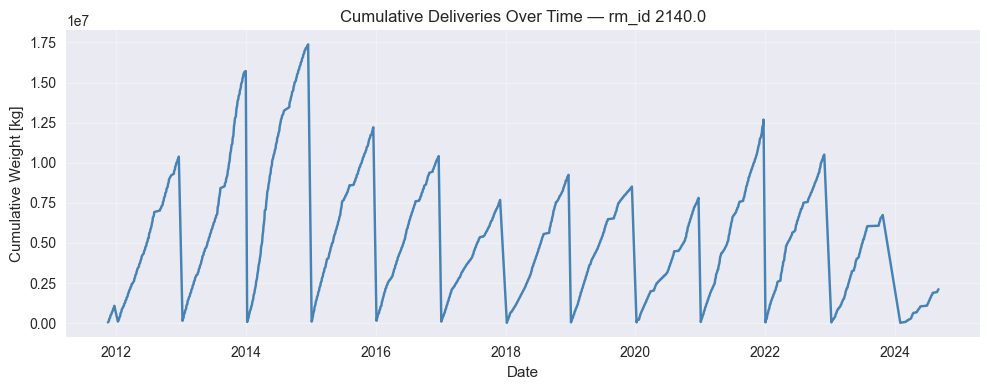

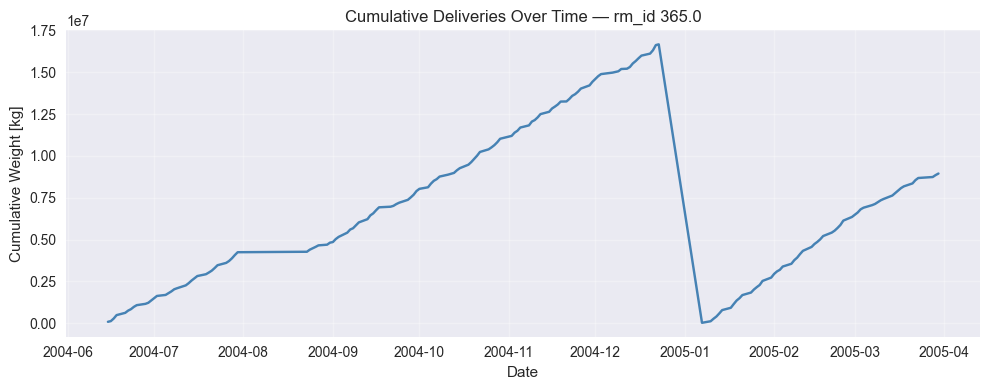

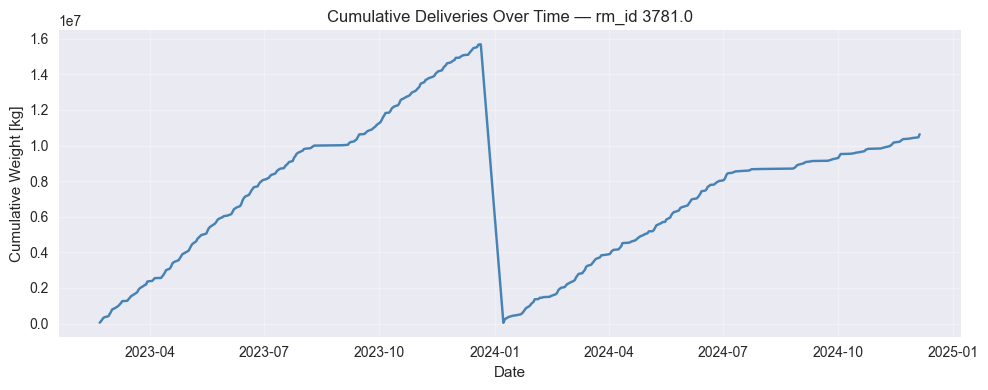

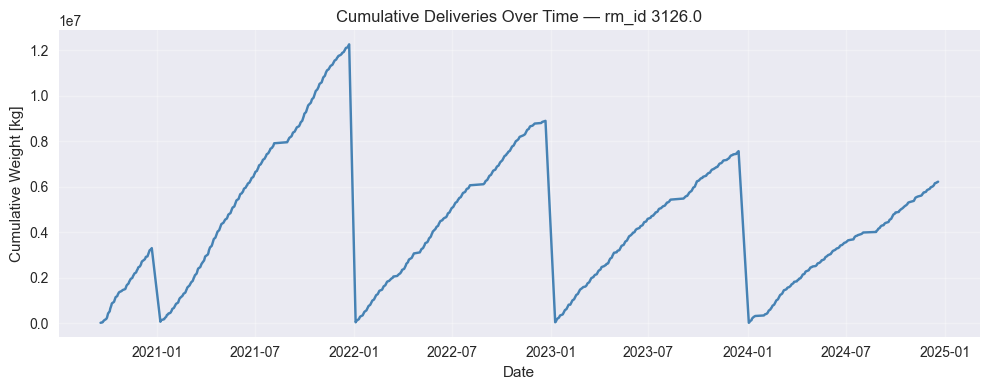

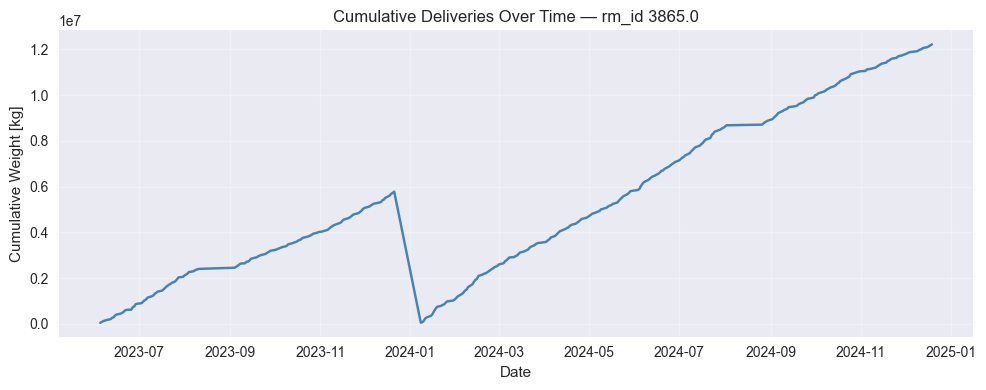

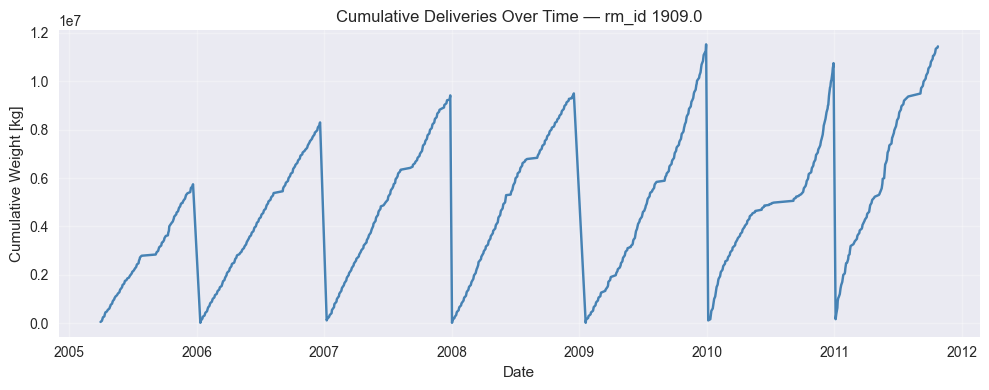

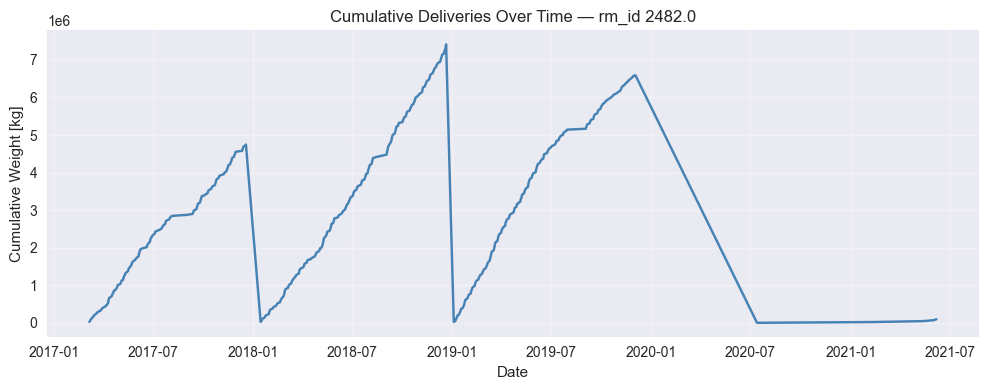

In [26]:
# EDA: Visualize cumulative receivals for top 10 rm_ids

import matplotlib.pyplot as plt

# Identify top 10 materials by total cumulative weight across all years
top10_rms = (
    receivals_ts.groupby("rm_id")["weight_kg"]
    .max()
    .sort_values(ascending=False)
    .head(10)
    .index
)

print("Top 10 rm_ids by total cumulative deliveries:", list(top10_rms))

# Combined overview plot
plt.figure(figsize=(12, 6))
for rm in top10_rms:
    subset = receivals_ts[receivals_ts["rm_id"] == rm]
    plt.plot(subset["forecast_end_date"], subset["weight_kg"], label=f"rm_id {rm}")

plt.title("Cumulative Raw Material Deliveries — Top 10 rm_ids")
plt.xlabel("Date")
plt.ylabel("Cumulative Delivered Weight [kg]")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Individual plots for each rm_id
for rm in top10_rms:
    subset = receivals_ts[receivals_ts["rm_id"] == rm]
    plt.figure(figsize=(10, 4))
    plt.plot(subset["forecast_end_date"], subset["weight_kg"], color="steelblue")
    plt.title(f"Cumulative Deliveries Over Time — rm_id {rm}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Weight [kg]")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### <a id='toc1_6_1_'></a>[Interpretation: Cumulative Receivals](#toc0_)

The cumulative-format plots show the expected **non-decreasing behavior** over time, confirming that the cumulative aggregation was applied correctly.  
We also observe that different materials have **very different start dates**, meaning not all raw materials were delivered throughout all years.  
Several materials display **unusual or irregular patterns** in some years, such as sudden jumps or flat periods, which likely correspond to erratic delivery schedules or temporary inactivity.  
Overall, many cumulative series appear roughly linear within active periods, suggesting that a **simple linear growth approximation** could serve as a reasonable first baseline model.


# <a id='toc2_'></a>[Feature Engineering](#toc0_)

We base the feature engineering on the daily level time series in receivals_daily_full because we also use them for our final model. The actual interval level time series is then created by just aggregating.

In [27]:
receivals_daily_full

,rm_id,date,net_weight
0,343.0,2004-06-15,0.0
1,343.0,2004-06-16,0.0
2,343.0,2004-06-17,0.0
3,343.0,2004-06-18,0.0
4,343.0,2004-06-19,0.0
...,...,...,...
1303777,4501.0,2024-12-15,0.0
1303778,4501.0,2024-12-16,0.0
1303779,4501.0,2024-12-17,0.0
1303780,4501.0,2024-12-18,0.0


,rm_id,date,net_weight,lag_1,lag_2,lag_3,lag_7,lag_30,lag_365,roll_mean_7,roll_mean_30,roll_mean_90,sin_dayofyear
0,343.0,2004-06-15,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263665
1,343.0,2004-06-16,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.247022
2,343.0,2004-06-17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.230306
3,343.0,2004-06-18,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.213521
4,343.0,2004-06-19,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.196673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303777,4501.0,2024-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3514.285714,1606.0,535.333333,-0.255353
1303778,4501.0,2024-12-16,0.0,0.0,0.0,0.0,24600.0,0.0,0.0,0.000000,1606.0,535.333333,-0.238673
1303779,4501.0,2024-12-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1606.0,535.333333,-0.221922
1303780,4501.0,2024-12-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1606.0,535.333333,-0.205104


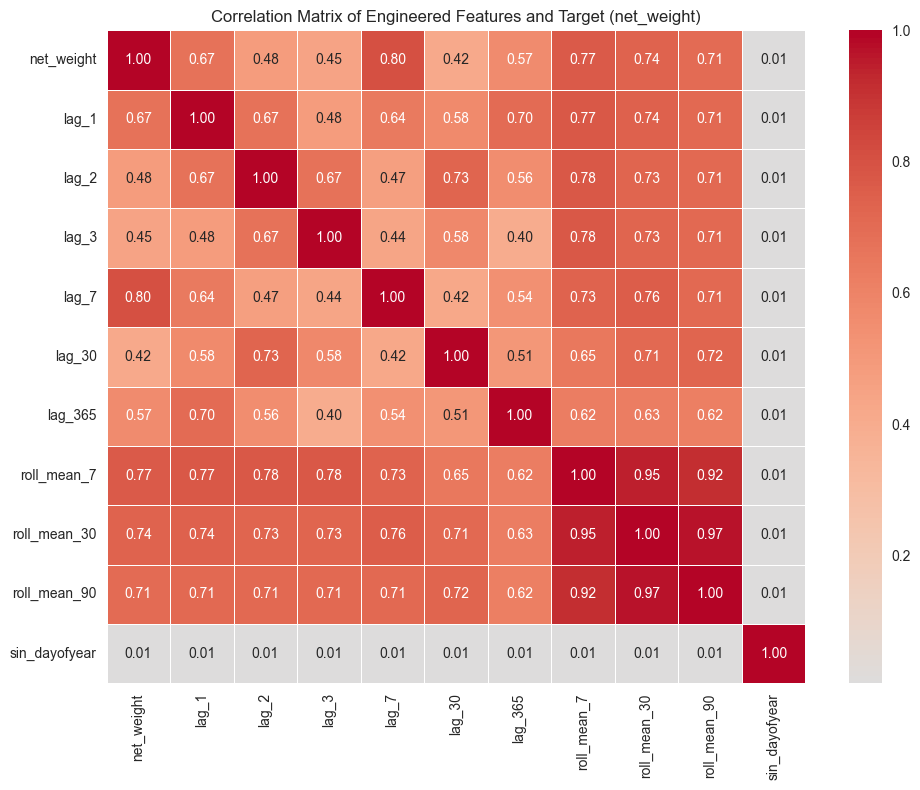

In [28]:
# Feature Engineering on receivals_daily_full

# Sort by rm_id and date to ensure correct temporal order
receivals_daily_full = receivals_daily_full.sort_values(["rm_id", "date"]).copy()

# Create lag features (1, 2, 3, 7 (week), 30 (month), 365 (year))
# We include these because we observed significant partial autocorrelation at short and weekly lags.
for lag in [1, 2, 3, 7, 30, 365]:
    receivals_daily_full[f"lag_{lag}"] = (
        receivals_daily_full.groupby("rm_id")["net_weight"].shift(lag)
    )

# Create rolling mean features
# Rolling averages smooth out short-term fluctuations and capture medium-term trends.
# The window sizes are chosen to reflect weekly (7d), monthly (30d), and quarterly (90d) patterns.
receivals_daily_full["roll_mean_7"] = (
    receivals_daily_full.groupby("rm_id")["net_weight"].transform(lambda x: x.rolling(7).mean())
)
receivals_daily_full["roll_mean_30"] = (
    receivals_daily_full.groupby("rm_id")["net_weight"].transform(lambda x: x.rolling(30).mean())
)
receivals_daily_full["roll_mean_90"] = (
    receivals_daily_full.groupby("rm_id")["net_weight"].transform(lambda x: x.rolling(90).mean())
)

# Add cyclic (non-linear) time feature for seasonal pattern capture
# sin(day_of_year) allows the model to learn periodic annual patterns without discontinuities.
receivals_daily_full["day_of_year"] = receivals_daily_full["date"].dt.dayofyear
receivals_daily_full["sin_dayofyear"] = np.sin(2 * np.pi * receivals_daily_full["day_of_year"] / 365)

# Drop the intermediate day_of_year column
receivals_daily_full = receivals_daily_full.drop(columns=["day_of_year"])

display(receivals_daily_full)

# Plot correlation matrix between all features and the target (net_weight)
# We use a subset of columns for readability
feature_cols = [
    "net_weight", "lag_1", "lag_2", "lag_3", "lag_7", "lag_30", "lag_365",
    "roll_mean_7", "roll_mean_30", "roll_mean_90", "sin_dayofyear"
]

corr_matrix = receivals_daily_full[feature_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix of Engineered Features and Target (net_weight)")
plt.tight_layout()
# plt.savefig('corr.png')
plt.show()

### <a id='toc2_1_1_'></a>[Feature Significance Analysis](#toc0_)

The correlation heatmap shows that most **lag and rolling mean features** have strong positive correlations with the target variable `net_weight`.  
This confirms that recent delivery quantities are good predictors of current-day deliveries, aligning with the **autocorrelation findings** from the ACF and PACF analysis.  

Among all features, **lag_1** and **lag_7** stand out as the most informative, reflecting short-term dependence and the weekly delivery cycle.  
The **rolling means** (7-, 30-, and 90-day) are also highly correlated with the target, as they smooth fluctuations and capture underlying delivery trends.  

In contrast, the **sin(dayofyear)** feature shows almost no linear correlation with `net_weight`.  
This suggests that annual seasonality is weak or non-linear in this dataset and likely less useful for predictive modeling.  
Overall, the correlation structure supports using recent lags and short- to medium-term rolling statistics as key temporal predictors for forecasting daily deliveries.


## <a id='toc2_2_'></a>[How were the receivals ordered?](#toc0_)

In [29]:
# Here we want to explore how the receivals were ordered and whether we can get meaningful features out of it.

### <a id='toc2_2_1_'></a>[Preprocess purchases](#toc0_)

In [30]:
# Parse dates
for col in ["created_date_time", "modified_date_time", "delivery_date"]:
    purchases[col] = (
        pd.to_datetime(purchases[col], utc=True, errors="coerce")
        .dt.tz_convert(None)
    )

# Numeric conversions
purchases["quantity"] = pd.to_numeric(purchases["quantity"], errors="coerce")
purchases["product_id"] = pd.to_numeric(purchases["product_id"], errors="coerce")
purchases["product_version"] = pd.to_numeric(purchases["product_version"], errors="coerce")

# Clean up and standardize the 'unit' column
purchases["unit"] = purchases["unit"].astype(str).str.strip().str.upper()
purchases.loc[purchases["unit"].isin(["nan", "", "NONE"]), "unit"] = "KG"  # treat missing as KG

# Convert quantities to kilograms
def convert_to_kg(row):
    if row["unit"] == "PUND":
        return row["quantity"] * 0.45359237
    # assume KG for all others (including NaN)
    return row["quantity"]

purchases["quantity"] = purchases.apply(convert_to_kg, axis=1)

# Drop invalid rows
purchases = purchases.dropna(subset=["product_id", "delivery_date"])

# Deduplicate
purchases = purchases.drop_duplicates(
    subset=["purchase_order_id", "purchase_order_item_no"], keep="last"
)

### <a id='toc2_2_2_'></a>[Compare actual arrival date and planned delivery date](#toc0_)

In [31]:
# Join delivery_date (and other columns) from purchases to receivals
# using purchase_order_id and purchase_order_item_no as join keys

receivals_merged = receivals.merge(
    purchases[
        ["product_id", "purchase_order_id", "purchase_order_item_no", "delivery_date", "quantity", "created_date_time"]
    ],
    on=["product_id", "purchase_order_id", "purchase_order_item_no"],
    how="left"
)

print(f"Successfully merged: {len(receivals_merged)} rows in receivals after join.")
display(receivals_merged.head())

Successfully merged: 114355 rows in receivals after join.


,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id,delivery_date,quantity,created_date_time
0,365.0,91900143.0,208545.0,10.0,1,NaN,2004-06-15 11:34:00,Completed,11420.0,52062,2004-12-30 23:00:00,1975000.0,2004-01-13 15:30:57
1,365.0,91900143.0,208545.0,10.0,2,NaN,2004-06-15 11:34:00,Completed,13760.0,52062,2004-12-30 23:00:00,1975000.0,2004-01-13 15:30:57
2,365.0,91900143.0,208490.0,10.0,1,NaN,2004-06-15 11:38:00,Completed,11281.0,50468,2004-12-30 23:00:00,1500000.0,2004-01-09 09:33:01
3,365.0,91900143.0,208490.0,10.0,2,NaN,2004-06-15 11:38:00,Completed,13083.0,50468,2004-12-30 23:00:00,1500000.0,2004-01-09 09:33:01
4,365.0,91900143.0,208532.0,10.0,1,NaN,2004-06-15 11:46:00,Completed,14840.0,20023,2004-12-30 23:00:00,3500000.0,2004-01-13 13:32:30


Summary of (arrival - delivery) time difference in days:
count    113348.000000
mean        -36.407956
std          96.981501
min        -723.000000
25%         -27.000000
50%         -15.000000
75%          -5.000000
max         794.000000
Name: days_diff, dtype: float64


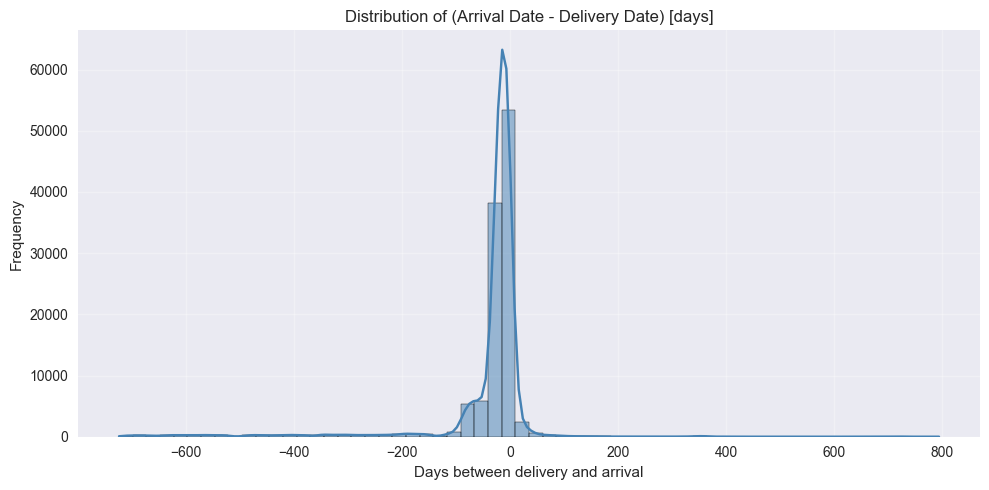

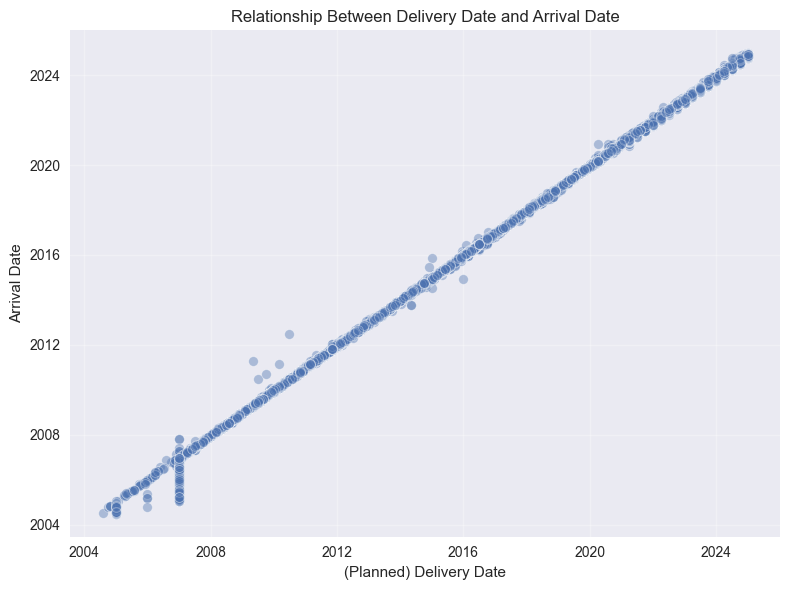

Correlation between delivery_date and date_arrival: 0.9989691300664085


In [32]:
# Compare delivery_date and arrival_date
# Goal: Check whether arrival_date can be inferred from delivery_date

# Convert to datetime just to be safe
receivals_merged["delivery_date"] = pd.to_datetime(receivals_merged["delivery_date"], errors="coerce")
receivals_merged["date_arrival"] = pd.to_datetime(receivals_merged["date_arrival"], errors="coerce")

# Compute the difference in days between arrival and delivery
receivals_merged["days_diff"] = (receivals_merged["date_arrival"] - receivals_merged["delivery_date"]).dt.days

# Remove unrealistic or missing differences
receivals_diff = receivals_merged.dropna(subset=["days_diff"])
receivals_diff = receivals_diff[(receivals_diff["days_diff"] > -4000) & (receivals_diff["days_diff"] < 4000)]

# Summary statistics
print("Summary of (arrival - delivery) time difference in days:")
print(receivals_diff["days_diff"].describe())

# Plot histogram of delivery-arrival time differences
plt.figure(figsize=(10, 5))
sns.histplot(receivals_diff["days_diff"], bins=60, kde=True, color="steelblue")
plt.title("Distribution of (Arrival Date - Delivery Date) [days]")
plt.xlabel("Days between delivery and arrival")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot to visualize the relationship between delivery_date and arrival_date
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="delivery_date",
    y="date_arrival",
    data=receivals_diff.sample(min(5000, len(receivals_diff))),  # sample for performance
    alpha=0.4
)
plt.title("Relationship Between Delivery Date and Arrival Date")
plt.xlabel("(Planned) Delivery Date")
plt.ylabel("Arrival Date")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Compute correlation coefficient
corr = receivals_diff["delivery_date"].map(pd.Timestamp.toordinal).corr(
    receivals_diff["date_arrival"].map(pd.Timestamp.toordinal)
)
print(f"Correlation between delivery_date and date_arrival: {corr}")

#### <a id='toc2_2_2_1_'></a>[Comparison of Delivery and Arrival Dates](#toc0_)

The comparison between `delivery_date` (from purchase orders) and `date_arrival` (from receivals) shows that **arrival dates typically occur earlier than delivery dates**, with an average difference of about **−36 days**.  
This negative mean indicates that, in the data, many receival records are logged before their corresponding delivery dates — likely due to inconsistencies or timing mismatches between the ordering and recording systems.  

The variation is large (standard deviation ≈ 97 days, ranging from −723 to +794 days), meaning that **there is no stable or predictable delay pattern** between the two timestamps.  
Even though the **correlation coefficient is high**, this mainly reflects the fact that both dates increase over time (they are time-dependent), **not** that one can accurately predict the arrival date from the delivery date.  
In summary, the relationship is **monotonic but not causal**, and the arrival date **cannot be reliably inferred** from the deliver date.


Below is an example illustrating **why it is very difficult to extract meaningful features from the `purchases` data**.  
For a single delivery (`purchase_order_id = 252001`, `purchase_order_item_no = 10`), we compare the corresponding entries across the `purchases`, `transportation`, and `receivals` datasets


In [33]:
# in purchases there is exactly one entry which states that 30600 KG of product_id 91900296 are ordered
# for delivery_date 2012-06-29 22:00:00

purchases[(purchases['purchase_order_id'] == 252001) & (purchases['purchase_order_item_no'] == 10)]

,purchase_order_id,purchase_order_item_no,quantity,delivery_date,product_id,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status
15000,252001,10,30600.0,2012-06-29 22:00:00,91900296,1,2012-06-18 08:54:16,2013-03-13 09:01:29,40.0,KG,2,Closed


In [34]:
# We now see in transportation that these 30600 KG will be splitted in 2 different trucks
# which can arrive at different times.

transportation[(transportation['purchase_order_id'] == 252001) & (transportation['purchase_order_item_no'] == 10)]

,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,transporter_name,vehicle_no,unit_status,vehicle_start_weight,...,net_weight,wood,ironbands,plastic,water,ice,other,chips,packaging,cardboard
41533,2157.0,91900296.0,252001.0,10.0,1,NaN,Transporter8,Vehicle2078,Transferred,35620.0,...,8700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41567,2157.0,91900296.0,252001.0,10.0,1,NaN,Transporter8,Vehicle3921,Transferred,37540.0,...,21900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# In receivals we see that the two trucks did arrive at different times, both approximately one month late.

receivals[(receivals['purchase_order_id'] == 252001) & (receivals['purchase_order_item_no'] == 10)]

,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id
41533,2157.0,91900296.0,252001.0,10.0,1,NaN,2012-07-24 14:00:00,Completed,8700.0,54963
41567,2157.0,91900296.0,252001.0,10.0,1,NaN,2012-07-25 13:24:00,Completed,21900.0,54963


#### <a id='toc2_2_2_2_'></a>[Continued Comparison of Delivery and Arrival Dates](#toc0_)

Two main issues prevent us from using the delivery information for modeling.  
First, the **arrival times are not truly linked to the delivery dates** in a consistent way. The differences between both timestamps vary widely and often do not follow a logical delay pattern, suggesting that they are recorded independently in different systems.  

Second, each purchase order in the `purchases` dataset can be **split into multiple separate shipments**, each arriving at a different time. These individual transportations are unpredictable and not represented in the available data. For upcoming orders (e.g., those expected in 2025), we cannot even determine **how many shipments or trucks** will be used, since no transportation-level details exist.  

As a result, the delivery information **does not provide any meaningful or reliable predictive signal**, and we therefore decide **not to include features derived from it** in our forecasting model.
